### prepair modules and bases settings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix,  classification_report, log_loss
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
from scipy.stats import norm
import scipy.io
import re
import itertools

import os
from os.path import join
import contextlib
from copy import deepcopy
import imp 
import time 
import sys

In [2]:
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn3
import numpy as np 

def two_way_varpart(A,B,AuB,correct_R2s=True,return_sep=True):
    """2-way variance partitioning. Handles scalars (single R2s) and vectors (multiple R2s).
    
    By default, this function implements a correction to handle cross-validated R2s. 
    That is, estimates and adds the smallest bias vector (in an L2-sense) such that the 
    set theoretic equations yield no inconsistent results. See De Heer, Huth, et al. 
    
    For info, see:
    - de Heer, Huth, et al. (2017) Journal of Neuroscience, 37(27), 6539-6557.

    In:
    positional args: 
    - (A,B,AuB): floats or np.array, shape(n_resp)
        R2 values for GLMs with each feature space, and the union of them. 
    - return_sep: bool (Default: True)
        if True, returns separate variable for each partition (i.e. as tuple of scalars/vectors)  
        If False, returns values in vectorised form (i.e. vector of scalars / matrix of row-vectors)
    -correct_R2s: Bool (Default: True)
        Implement correction to avoid impossible values.
    
    Out:
    - 6 separate variables for each (adjusted) input R2 and each partition 
        if return_sep=True
    OR
    - 1 variable for all (adjusted) input R2s and partitions 
        (6-dimensional vector if input is scalar; (6 x n_resp) dim matrix if input is vector)
    order of output:
    (A,B,C, AuB, # input R2s (adjusted values if needed)
     A*,B*, AnB) # output partitions
    
    -------
    MH 2020
    -------
    """
    eqs=np.array([[0,-1,1],  # A_ =  AuB - B 
                  [-1,0,1],  # B_ =  AuB - A 
                  [1,1,-1]]) # AnB=  A+B -AuB 
    all_ABAuB=np.vstack((A,B,AuB))
    all_ABAuB[all_ABAuB<0]=0 # ignore negative values 
    
    # estimate biases (still iterative over responses...)
    all_biases=np.zeros_like(all_ABAuB)
    if correct_R2s:
        for vox_i, ABAuB in enumerate(all_ABAuB.T):
            all_biases[:,vox_i]=_est_bias_2wayVP(ABAuB[0],ABAuB[1],ABAuB[2])
        
    all_ABAuB_adjusted=all_ABAuB+all_biases
    all_A_B_AnB=eqs.dot(all_ABAuB_adjusted)

    if return_sep: # if return values as separate variables (i.e. as tuple of scalars/vectors)
        return(all_ABAuB_adjusted[0],all_ABAuB_adjusted[1],all_ABAuB_adjusted[2],
           all_A_B_AnB[0],all_A_B_AnB[1],all_A_B_AnB[2])
    else: # if return vectorised form 
        return(np.vstack((all_ABAuB_adjusted,all_A_B_AnB)))

def _est_bias_2wayVP(A,B,AuB):
    """estimate bias vector for A*,B* and AnB in 2 way variance partitioning.
    in:
    - A,B,AuB: floats
        R2 for A B and AuB feauterespaces
    returns:
    -b123: bias vector for A,B,AnB
    """
    def obj(x):
        return(np.linalg.norm(x)) #  l2 norm 

    def c1(x): # A_ >=0; in other words, AuB+x[2] - B+x[1] >=0
        return((AuB+x[2]) - (B+x[1]))

    def c2(x): # B_ >=0; in other words, AuB+x[2] - A+x[0] >=0
        return((AuB+x[2]) - (A+x[0]))

    def c3(x): # AnB >=0; in other words, (A+x[0]) + (B+x[1]) - (AuB+x[2])] >=0
        return((A+x[0]) + (B+x[1]) - (AuB+x[2]))
    cons=(
        {'type':'ineq','fun':c1},
        {'type':'ineq','fun':c2},
        {'type':'ineq','fun':c3},
    )
    res=minimize(obj,np.random.rand(3)*.001,constraints=cons,bounds=((None,0),)*3,)
    if not res.success: 
        print('initial faillure... trying harder......')
        res = minimize(obj,np.random.rand(3)*.001,constraints=cons,bounds=((None,0),)*3,
                      method='SLSQP',options={'maxiter':999})
        if res.success: return(res.x)
        else: # if still not, check what's happening 
            print('A',A);print('B:',B);print('AuB',AuB)
            set_trace() # to be commented later on
            return(np.nan(3))
    else: 
        return(res.x)
def _est_bias_3wayVP(A,B,C,AuB,AuC,BuC,AuBuC, only_overlap=True):
    """estimate bias vector for A*,B*,C* and AnB,AnC,BnC,AnBnC in 3 way variance partitioning.
    in:
    - A,B,C,AuB,AuC,BuC,AuBuC: floats
        R2 for A B and AuB feauterespaces
    returns:
    -b123: bias vector for A,B,C,AuB,AuC,BuC,AuBuC
    """
    def obj(x):
        return(np.linalg.norm(x)) #  l2 norm 
    
    def c1(x): # A*  = AuBuC - BuC  
        return((AuBuC+x[6]) - (BuC+x[5]))
    def c2(x): # B* >=0; in other words:  (AuBuC+x[6]) - (AuC+x[4]) >=0
        return((AuBuC+x[6]) - (AuC+x[4]))
    def c3(x): # C*  >=0; in other words AuBuC - AuB
        return((AuBuC+x[6]) - (AuB+x[3]))
    def c4(x):# AnB*= AuC + BuC - C - AuBuC
        return((AuC+x[4]) + (BuC+x[5]) - (C+x[2])- (AuBuC+x[6]))
    def c5(x):# AnC* = AuB + BuC - B - AuBuC
        return((AuB+x[3]) + (BuC+x[5]) - (B+x[1])- (AuBuC+x[6]))
    def c6(x):# BnC*= AuB + AuC - A - AuBuC
        return((AuB+x[3]) + (AuC+x[4]) - (A+x[0])- (AuBuC+x[6]))
    def c7(x):# AnBnC =  AuBuC + A+B+C - AuB - AuC -BuC
        return((AuBuC+x[6]) + (A+x[0]) + (B+x[1]) + (C+x[2]) -
               (AuB+x[3]) - (AuC+x[4]) - (BuC+x[5]))
    
    # define constraintes: all funcs >=0
    np.random.seed(123)
    if only_overlap == True: 
        cons=tuple({'type':'ineq','fun':c} for c in [c4,c5,c6,c7])
        res=minimize(obj,np.random.rand(7)*-.0001,constraints=cons,bounds=((None,0),)*7,)
    else: 
        cons=tuple({'type':'ineq','fun':c} for c in [c1,c2,c3,c4,c5,c6,c7])   
        res=minimize(obj,np.random.rand(7)*-.0001,constraints=cons,bounds=((None,0),)*7,)
    
    if not res.success: 
        print('initial faillure... trying harder......')
        res = minimize(obj,np.random.rand(7)*-.0001,constraints=cons,bounds=((0,None),)*7,
                      method='SLSQP',options={'maxiter':999})
        if res.success: return(res.x)
        else: # if still not, check what's happening 
            print('A',A);print('B:',B);print('AuB',AuB)
            set_trace() # to be commented later on
            return(np.nan(3))
    else: 
        return(res.x)


In [3]:
# load local functions
import stim_io
import stim_io_plotting
import vtc

/home/jorvhar/miniconda3/envs/predlis/lib/python3.8/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


In [4]:
# plotting bases settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial',
                                   "Helvetica"]
plt.rcParams['figure.dpi']= 150
sns.set_style('white')


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## General settings

In [5]:
pp = 2
input_dir = '/media/jorvhar/Data1/MRIData/timing data/data/'

tr = 1.8
volumes = 235
nr_runs=12

In [6]:
# settings
mat = scipy.io.loadmat(join(input_dir,'{}/{}_settings_tonotopy.mat'.format(pp, pp)))
all_freqs = mat['cfg']['freq_array'][0][0][0,:]

# must match the tonotopy settings
tunsteps       = 10
freqstep       = 1
subsample      = np.arange(0,len(all_freqs), freqstep)
mustep         = np.diff(all_freqs[subsample])
muarray_bins   = all_freqs
muarray        = all_freqs[subsample]

# tuning sizes
fwhm           = np.linspace(1,(8), tunsteps)
octgrid        = fwhm / (2*np.sqrt(2*np.log(2)))
sigmagrid      = 2**octgrid

# set range of tunings and sharpnesses
pref_range  = muarray                # match t
sharp_range_fwhm = fwhm
sharp_range = octgrid                # check if correct, fwhm or sigma of gaussian?



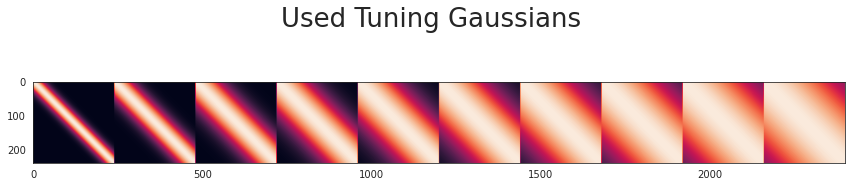

In [7]:
ax, fig = stim_io_plotting.freqs_plot(pref_range, sharp_range)

## 1. Load the data
### a. stimuli data

In [8]:
puls_df = stim_io.pulses_load(str(pp), input_dir, 12)
volumes_df = stim_io.volumes_load(puls_df, tr, volumes, nr_runs=12)

mat, stimuli = stim_io.data_load(str(pp), join(input_dir, str(pp)))
stim_df = stim_io.stims_load(puls_df, volumes_df, mat, stimuli)

### b. add DREX data

In [9]:
## create drex matfiles for all pps
# for pp in [3, 4, 5, 6, 7, 8, 9]:
#     stim_io.stims_export_mat(str(pp), input_dir, stim_df, pref_range)
#     stim_io.run_drex(str(pp), input_dir) # only have to do this once

In [10]:
stim_io.stims_export_mat(str(pp), input_dir, stim_df, pref_range)
#stim_io.run_drex(str(pp), input_dir) # only have to do this once
stim_df = stim_io.stims_add_drex(str(pp), input_dir, stim_df)

<AxesSubplot:>

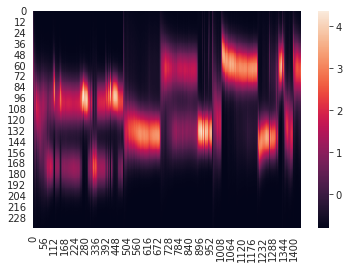

In [11]:
# quick senity check
run = 5
predprobz = stim_df[stim_df['run'] == run].filter(regex='pred_prob[_0-9.]+').to_numpy()

# z-score 
#  note: do we want to z-score the regressors over all voxels, otherwise we boost oudside range areas more
predprobz = (predprobz - predprobz.mean()) / predprobz.std()
#predprobz = (predprobz - predprobz.mean(axis=0)) / predprobz.std(axis=0) # dont do this

sns.heatmap( predprobz.transpose() )

### c. add adaptation data

In [12]:
import Adaptation.longtrace_adaptation as longtrace_adaptation
x_decay, y_decay = longtrace_adaptation.double_exp_decay_func(0.1399, 0.85, 0.0345, 6.82, [1, 10], 1)

activations, adaptations, adapted_activations, n_back_adaptations = stim_io.run_adaptation(stim_df, 
                                                                                           pref_range, 
                                                                                           sharp_range, 
                                                                                           y_decay)
stim_df = stim_io.stims_add_adaptation(stim_df, 
                                       pref_range, 
                                       sharp_range, 
                                       activations, 
                                       1-adaptations,       # take 1-adaptation to make filling with 0s possible
                                       adapted_activations)

# cleanup collumns
del activations, adaptations, adapted_activations, n_back_adaptations

## 2. TR domain transfer

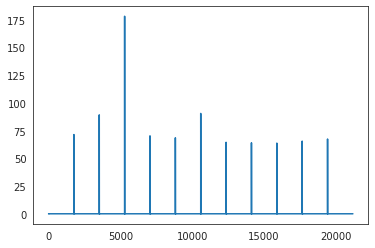

In [13]:
# main function for adding timesteps (inbetween runs, / blocks)
stim_df = stim_io.stims_add_temporal_pad(stim_df, volumes_df)

# sanity check timing diffs
plt.plot(stim_df['timing'].diff())

In [14]:
# load cononical hrf
hrf = scipy.io.loadmat('/media/jorvhar/Data1/MRIData/timing data/hrf.mat')
newhrf = stim_io.con_hrf_stimdomain(hrf, stim_df, plotres=False)

# convolve stim_df with hrf (the regressors)
stim_df = stim_io.stims_convolve_hrf(stim_df, newhrf)

In [15]:
# to get dataframe in tr space, simply 
# then, when we want to do the FIR, we can do this groupby sum approach, and take the non-convolved, and shift() some steps
  #tr_df = stim_df.groupby(['volume_abs']).sum()
    
tr_df = stim_io.stims_to_tr(stim_df, volumes_df, downsample_unconv=False)

In [16]:
print(f'Prefrange: \n {np.round(pref_range,4)}\n\nSharprange: \n {np.round(sharp_range,4)}')

p = pref_range[30]
t = sharp_range[5]

stim_io.get_tw_collumns(tr_df, p, t, convolved=True)

Prefrange: 
 [ 7.6439  7.6644  7.6849  7.7054  7.726   7.7465  7.767   7.7876  7.8081
  7.8286  7.8492  7.8697  7.8902  7.9108  7.9313  7.9518  7.9724  7.9929
  8.0134  8.0339  8.0545  8.075   8.0955  8.1161  8.1366  8.1571  8.1777
  8.1982  8.2187  8.2393  8.2598  8.2803  8.3008  8.3214  8.3419  8.3624
  8.383   8.4035  8.424   8.4446  8.4651  8.4856  8.5062  8.5267  8.5472
  8.5677  8.5883  8.6088  8.6293  8.6499  8.6704  8.6909  8.7115  8.732
  8.7525  8.7731  8.7936  8.8141  8.8346  8.8552  8.8757  8.8962  8.9168
  8.9373  8.9578  8.9784  8.9989  9.0194  9.04    9.0605  9.081   9.1016
  9.1221  9.1426  9.1631  9.1837  9.2042  9.2247  9.2453  9.2658  9.2863
  9.3069  9.3274  9.3479  9.3685  9.389   9.4095  9.43    9.4506  9.4711
  9.4916  9.5122  9.5327  9.5532  9.5738  9.5943  9.6148  9.6354  9.6559
  9.6764  9.6969  9.7175  9.738   9.7585  9.7791  9.7996  9.8201  9.8407
  9.8612  9.8817  9.9023  9.9228  9.9433  9.9639  9.9844 10.0049 10.0254
 10.046  10.0665 10.087  10.1076 10.128

['pred_prob_8.260_convolved',
 'raw_acti_8.260_2.076_convolved',
 'raw_adapt_8.260_2.076_convolved',
 'adapt_activ_8.260_2.076_convolved',
 'surprisal_convolved',
 'onoff_convolved']

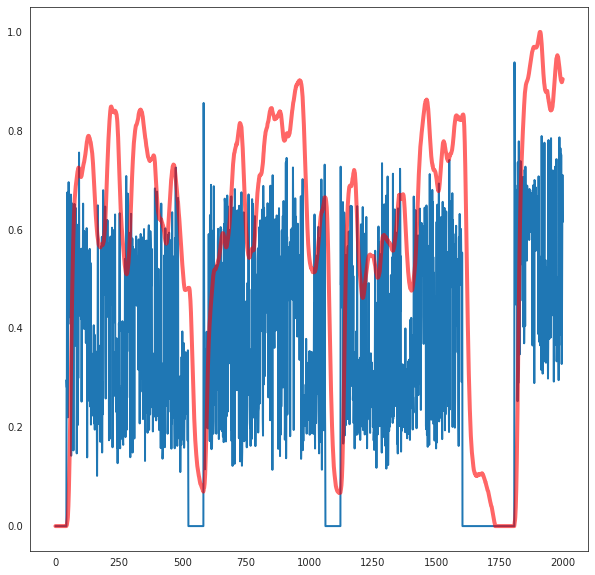

In [17]:
# check if worked
start = 0
end = 2000
ax, fig = plt.subplots(1, 1, figsize=(10,10))
plt.plot(stim_df[f'adapt_activ_{p:.3f}_{t:.3f}'][start:end], lw=2)
plt.plot(stim_io.normalize(stim_df[f'adapt_activ_{p:.3f}_{t:.3f}_convolved'][start:end]),color='r', alpha=0.6, lw=4)

In [18]:
stim_df[stim_df['frequencies'].notnull()]

,frequencies,frequencies_oct,timing,closest_volume_rel,closest_volume_abs,volume_rel,volume_abs,run,block,segment,...,adapt_activ_12.407_3.397_convolved,adapt_activ_12.428_3.397_convolved,adapt_activ_12.448_3.397_convolved,adapt_activ_12.469_3.397_convolved,adapt_activ_12.489_3.397_convolved,adapt_activ_12.510_3.397_convolved,adapt_activ_12.530_3.397_convolved,adapt_activ_12.551_3.397_convolved,surprisal_convolved,onoff_convolved
44,2896.309376,11.500000,607363.205175,5,5,5,5,1.0,1.0,1.0,...,0.073586,0.073466,0.073343,0.073218,0.073091,0.072961,0.072829,0.072694,1.124914,0.076256
45,2896.309376,11.500000,607363.455175,5,5,5,5,1.0,1.0,1.0,...,0.120823,0.120647,0.120466,0.120282,0.120094,0.119902,0.119707,0.119508,1.837960,0.138041
46,966.527296,9.916667,607363.705175,5,5,6,6,1.0,1.0,1.0,...,0.165346,0.164987,0.164623,0.164255,0.163883,0.163506,0.163126,0.162741,2.829782,0.211297
47,912.280287,9.833333,607363.955175,5,5,6,6,1.0,1.0,1.0,...,0.243098,0.242542,0.241980,0.241412,0.240837,0.240257,0.239670,0.239077,4.210029,0.318462
48,2298.802275,11.166667,607364.205175,5,5,6,6,1.0,1.0,1.0,...,0.374574,0.373840,0.373096,0.372341,0.371576,0.370801,0.370016,0.369221,6.289579,0.478473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21014,767.133223,9.583333,613497.053499,212,2797,212,2797,12.0,36.0,10.0,...,13.867458,13.824541,13.781330,13.737827,13.694032,13.649950,13.605580,13.560927,284.858241,25.498072
21015,2169.780417,11.083333,613497.303499,212,2797,213,2798,12.0,36.0,10.0,...,13.895039,13.852268,13.809200,13.765838,13.722182,13.678236,13.634001,13.589479,284.746663,25.498072
21016,1024.000000,10.000000,613497.553499,212,2797,213,2798,12.0,36.0,10.0,...,13.899326,13.856505,13.813386,13.769972,13.726265,13.682267,13.637980,13.593406,284.261572,25.498072
21017,645.079578,9.333333,613497.803499,212,2797,213,2798,12.0,36.0,10.0,...,13.914815,13.872079,13.829045,13.785715,13.742091,13.698174,13.653967,13.609472,283.908371,25.498072


In [19]:
# fig, ax = plt.subplots(2, 
#                        1, 
#                        sharex=True,
#                        gridspec_kw={'height_ratios': [3, 1]}, figsize=(10,  7.5))

# tempdf = stim_df[tr_df['run'].isin(np.arange(1,2,1))]

# ax[0].scatter(tempdf['timing'], tempdf['frequencies_oct'], color='darkslategrey', alpha=0.8)

In [20]:
tempdf = tr_df[tr_df['run'].isin(np.arange(1,2,1))]

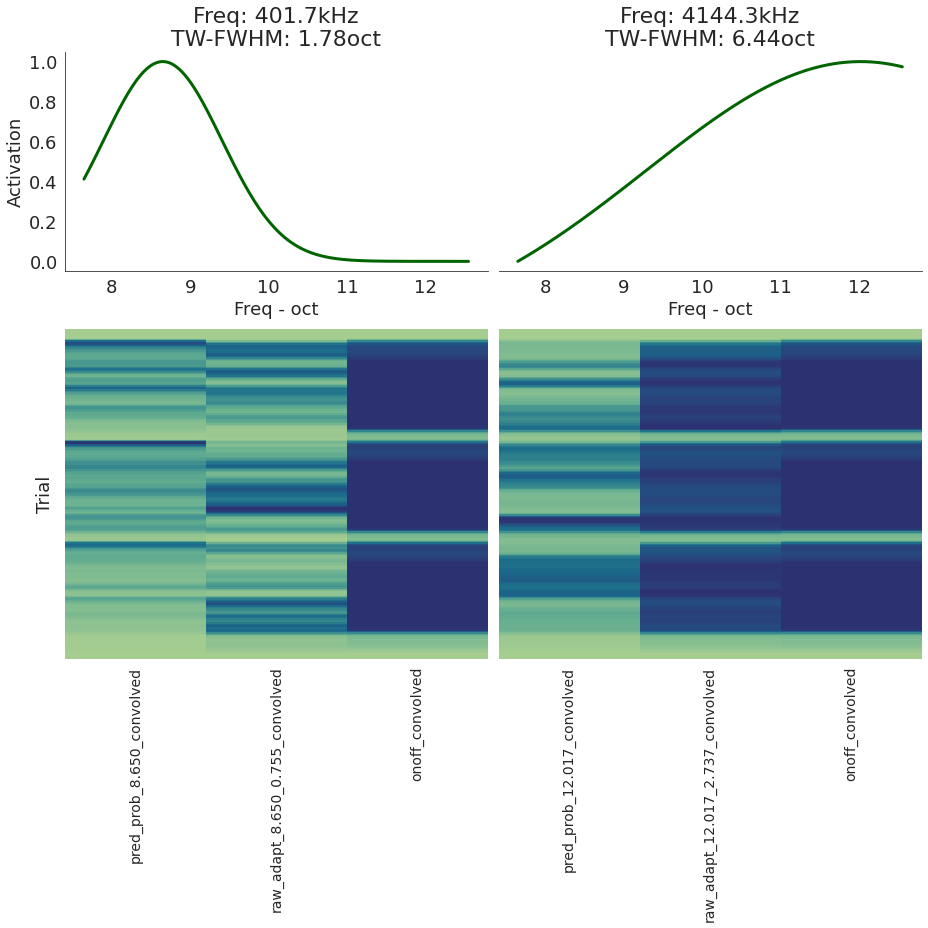

In [21]:
pref1 = 8.6499
pref2 = 12.0169

tw1 = 0.755
tw2 = 2.7367

col_oi = ['pred', 'raw_adapt', 'onoff_con']

ax, fig = stim_io_plotting.plot_design_mat(tr_df, all_freqs, pref1, tw1, pref2, tw2, runs=np.arange(1,2,1),
                                          prefixes= col_oi)
# ax, fig = stim_io_plotting.plot_design_mat(tr_df, all_freqs, pref1, tw1, pref2, tw2, runs=np.arange(1,7,1))

## 2. Loading data
- per hemisphere
- per big area of interest

In [3]:
import bvbabel
from os.path import join
import matplotlib.pyplot as plt

mridat_dir = '/media/jorvhar/Data8T/MRIData/PreProc'
pp_dir = lambda pp, ses : f'S{pp:02d}_SES{ses}'
vmpfn = lambda hemisphere, depth : f'Betas/session2_{hemisphere}_D{depth}.vmp'

head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn('RH', 2)))

In [4]:
[head['Map'][i]['MapName'] for i in range(len(head['Map']))]

['base_U_adaptation (non-cv)',
 'prediction (non-cv)',
 'base_U_adaptation_U_prediction (non-cv)',
 'base_unique (non-cv)',
 'pred_unique (non-cv)',
 'base_N_adaptation_N_prediction (non-cv)',
 'base_U_adaptation (cv mean)',
 'prediction (cv mean)',
 'base_U_adaptation_U_prediction (cv mean)',
 'base_unique (cv mean)',
 'pred_unique (cv mean)',
 'base_N_adaptation_N_prediction (cv mean)']

In [6]:
cond_names = [head['Map'][i]['MapName'] for i in range(len(head['Map']))]
cond_names.index('base_U_adaptation_U_prediction (non-cv)')

2

In [25]:
cond_names = [head['Map'][i]['MapName'] for i in range(len(head['Map']))]
print(cond_names)

# get index of condition
cond_idx = cond_names.index('base_U_adaptation_U_prediction (non-cv)')

# sellect condtion
img_oi = img[:,:,:,cond_idx]

['base_U_adaptation (non-cv)', 'prediction (non-cv)', 'base_U_adaptation_U_prediction (non-cv)', 'base_unique (non-cv)', 'pred_unique (non-cv)', 'base_N_adaptation_N_prediction (non-cv)', 'base_U_adaptation (cv mean)', 'prediction (cv mean)', 'base_U_adaptation_U_prediction (cv mean)', 'base_unique (cv mean)', 'pred_unique (cv mean)', 'base_N_adaptation_N_prediction (cv mean)']


In [58]:
import nibabel as nb

# maskfile
mskloc = '/media/jorvhar/Data1/OneDrive_Mint/Documenten/Matlab and Python short scripts/regresiiontesting/segmasks/pp1/Segmentation-label.nii.gz'
# mskloc = '/media/jorvhar/Data1/OneDrive_Mint/Documenten/Matlab and Python short scripts/regresiiontesting/segmasks/pp2/Segmentation-label.nii.gz'


# Load Nifti
nii = nb.load(mskloc)
nii_data = np.nan_to_num(nii.get_fdata(), nan=0.)

# mask
frontal = nii_data == 1
auditory = nii_data == 2

In [27]:
# # define only for frontal and auditory
# img_oi_front = img_oi[frontal]
# img_oi_aud = img_oi[auditory]

In [31]:
head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn('RH', 2)))

cond_A = cond_names.index('base_U_adaptation (non-cv)')
cond_B = cond_names.index('prediction (non-cv)')
cond_AuB = cond_names.index('base_U_adaptation_U_prediction (non-cv)')

A = img[:,:,:,cond_A][frontal]
B = img[:,:,:,cond_B][frontal]
AuB = img[:,:,:,cond_AuB][frontal]

plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=1)



AttributeError: 'int' object has no attribute 'set_aspect'

In [1]:
# get bax amongst models within voxel
grandmax = np.vstack((A,B, AuB)).max(axis=0)

# get max indexes
maxidx = np.argsort(grandmax)[-500:]
top_500_values = grandmax[maxidx]
top_500_values

NameError: name 'np' is not defined

In [ ]:
# lbls=['Baseline \n (low-level + adaptation)','Expectations \n (D-Rex)']

# fig, ax = plt.subplots(3,2, figsize=(18, 18))
# plt.title('Model Fit\nPrediction dominated', fontsize=title_size)

# fg= plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), #ax=ax[d, i],
#                         labels=lbls,avgfun=np.mean, alpha=1)
# fg = pimpcollors_venn2(fg)

In [ ]:
# 2000 results look oke, especially for auditory, cv everywhere 
# 

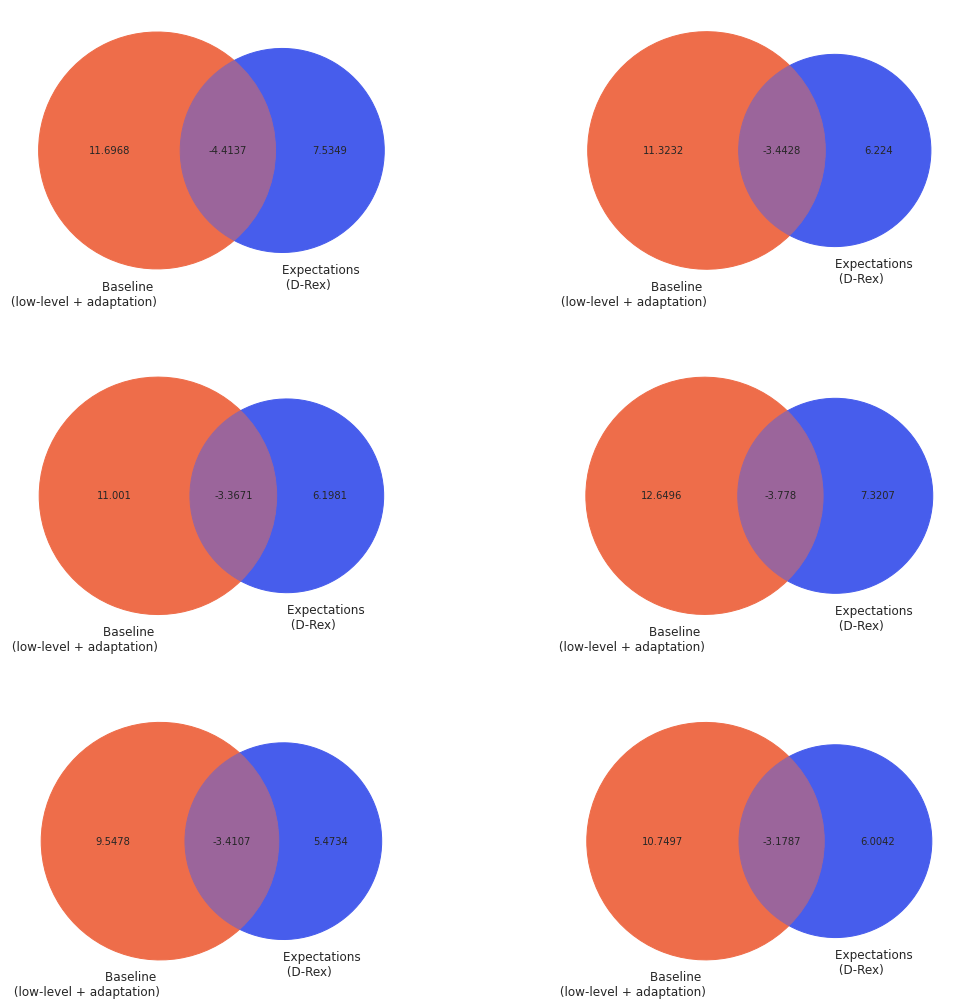

In [49]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

lbls=['Baseline \n (low-level + adaptation)','Expectations \n (D-Rex)']
hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(2, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (non-cv)')
        cond_B = cond_names.index('prediction (non-cv)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (non-cv)')

        A = img[:,:,:,cond_A][frontal]
        B = img[:,:,:,cond_B][frontal]
        AuB = img[:,:,:,cond_AuB][frontal]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-2000:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

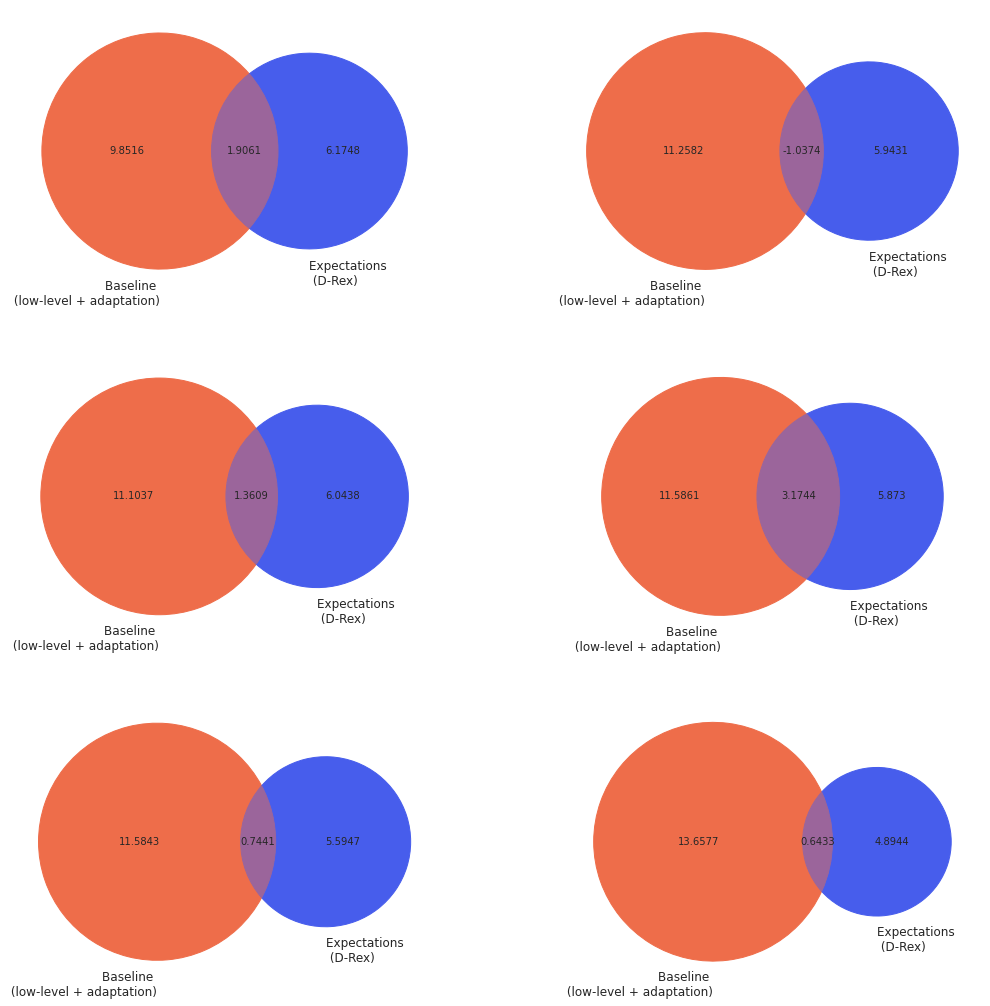

In [50]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(2, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (non-cv)')
        cond_B = cond_names.index('prediction (non-cv)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (non-cv)')

        A = img[:,:,:,cond_A][auditory]
        B = img[:,:,:,cond_B][auditory]
        AuB = img[:,:,:,cond_AuB][auditory]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-2000:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

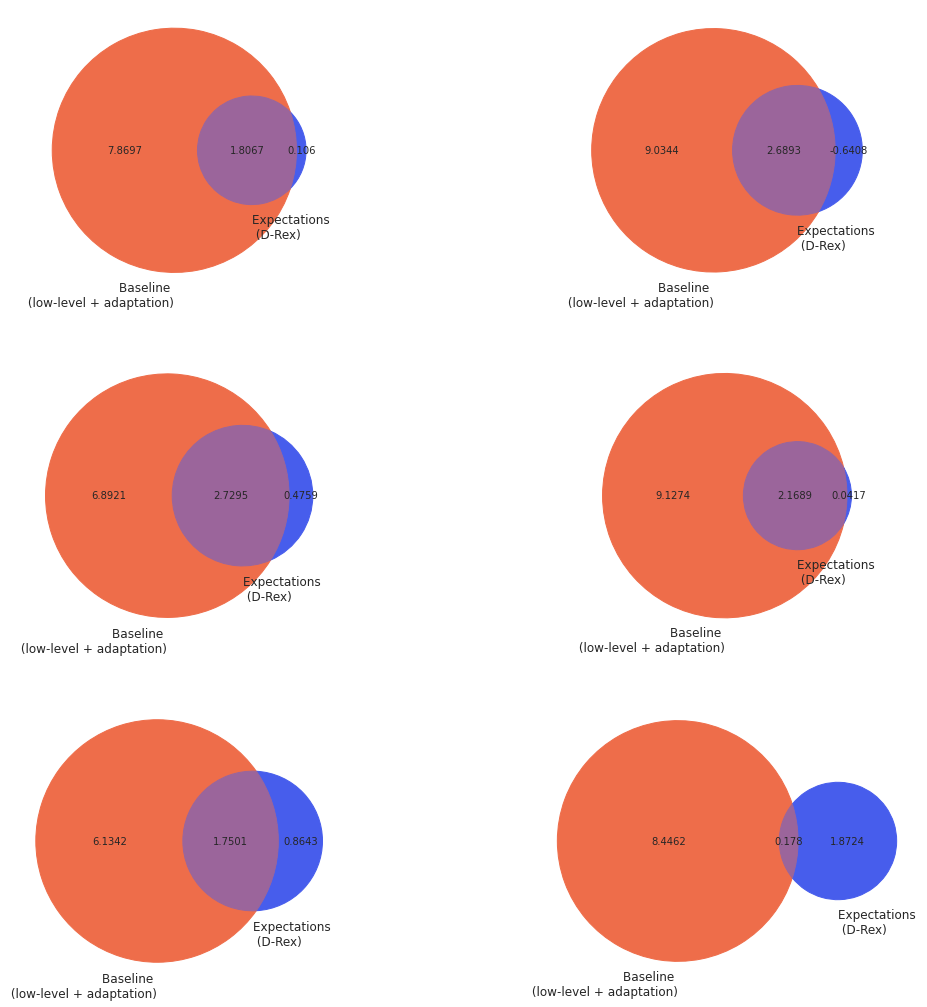

In [34]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (cv mean)')
        cond_B = cond_names.index('prediction (cv mean)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (cv mean)')

        A = img[:,:,:,cond_A][frontal]
        B = img[:,:,:,cond_B][frontal]
        AuB = img[:,:,:,cond_AuB][frontal]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-5000:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

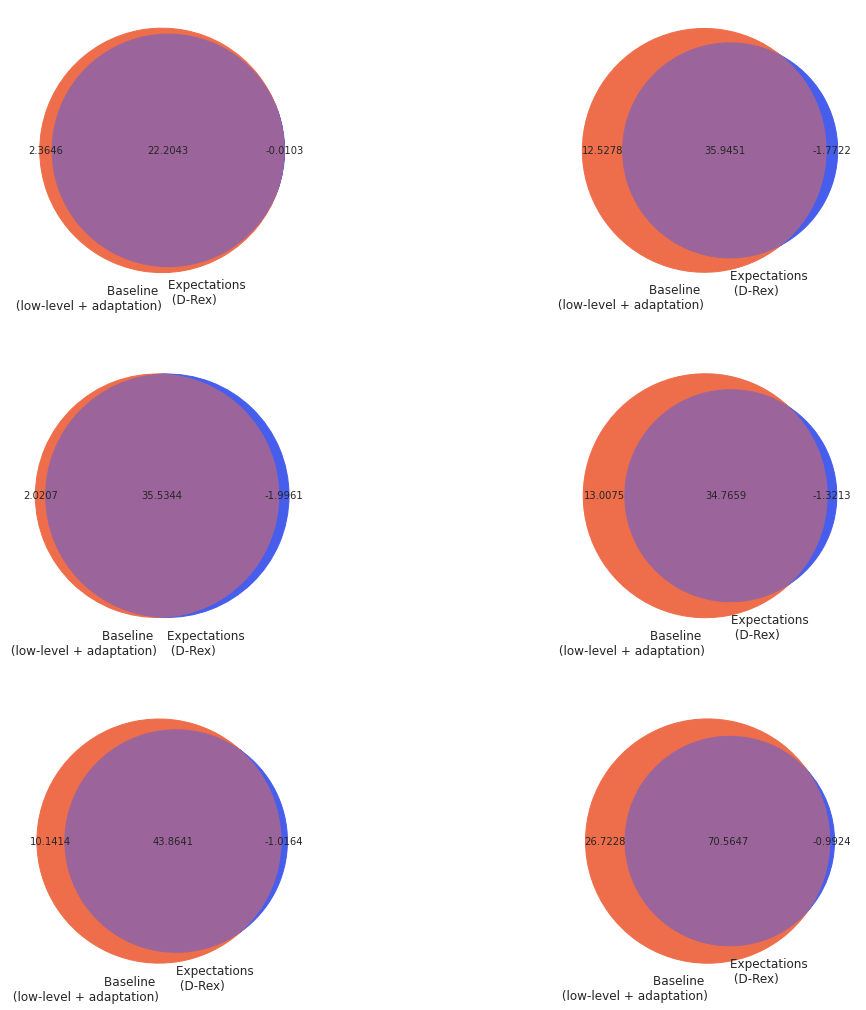

In [35]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (cv mean)')
        cond_B = cond_names.index('prediction (cv mean)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (cv mean)')

        A = img[:,:,:,cond_A][auditory]
        B = img[:,:,:,cond_B][auditory]
        AuB = img[:,:,:,cond_AuB][auditory]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-5000:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

In [51]:
# other amount of voxels

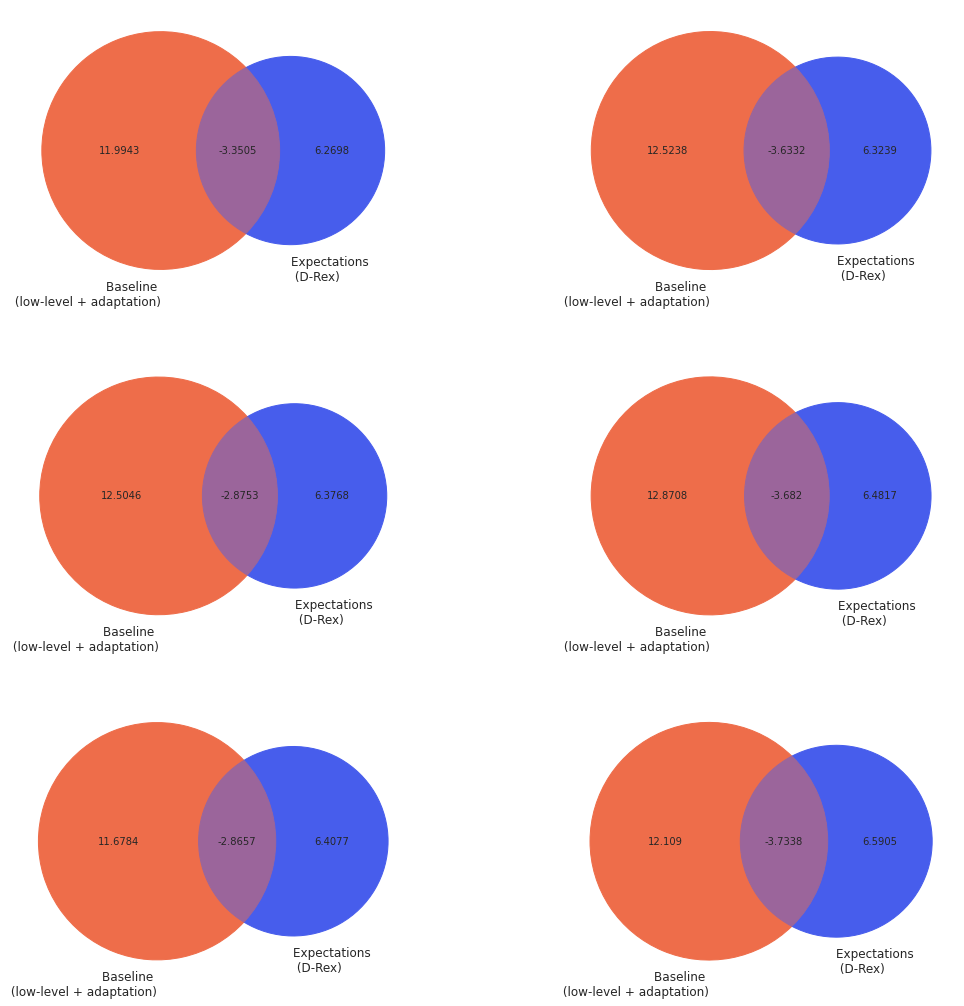

In [59]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))
 
lbls=['Baseline \n (low-level + adaptation)','Expectations \n (D-Rex)']
hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (non-cv)')
        cond_B = cond_names.index('prediction (non-cv)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (non-cv)')

        A = img[:,:,:,cond_A][frontal]
        B = img[:,:,:,cond_B][frontal]
        AuB = img[:,:,:,cond_AuB][frontal]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-5000:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

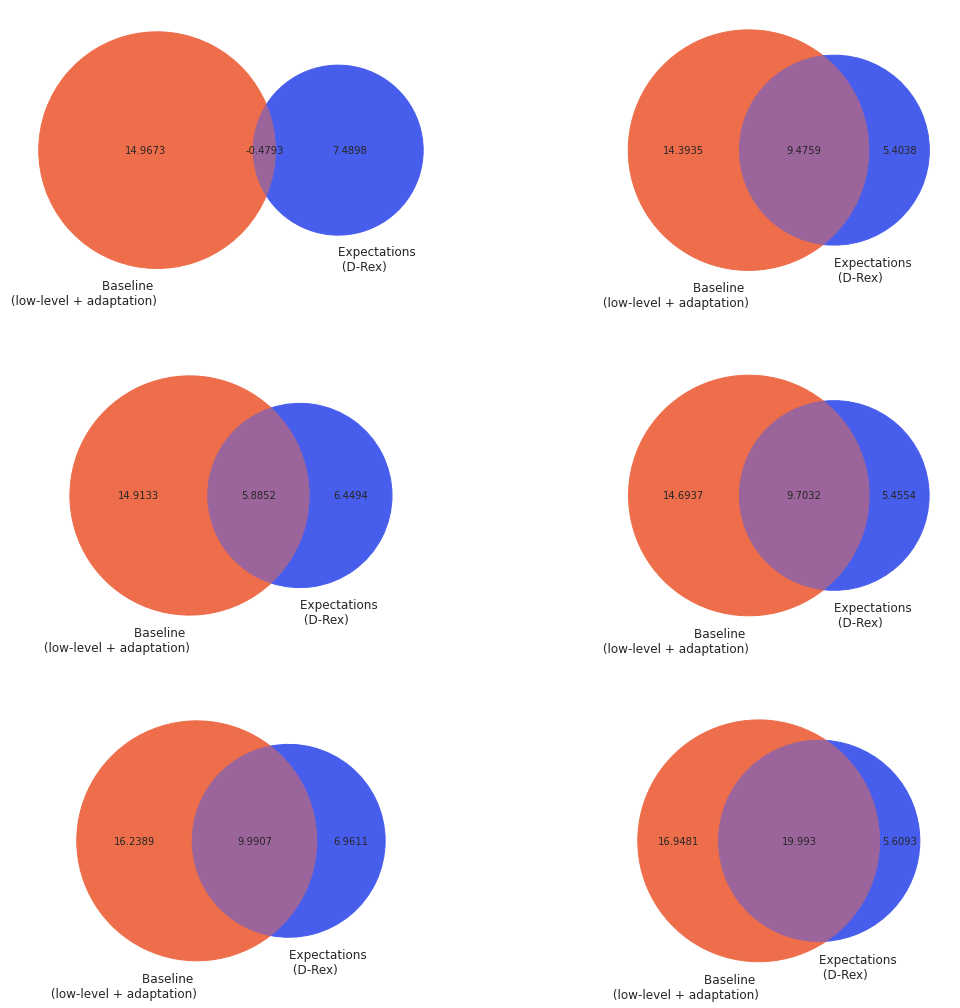

In [60]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (non-cv)')
        cond_B = cond_names.index('prediction (non-cv)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (non-cv)')

        A = img[:,:,:,cond_A][auditory]
        B = img[:,:,:,cond_B][auditory]
        AuB = img[:,:,:,cond_AuB][auditory]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-5000:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

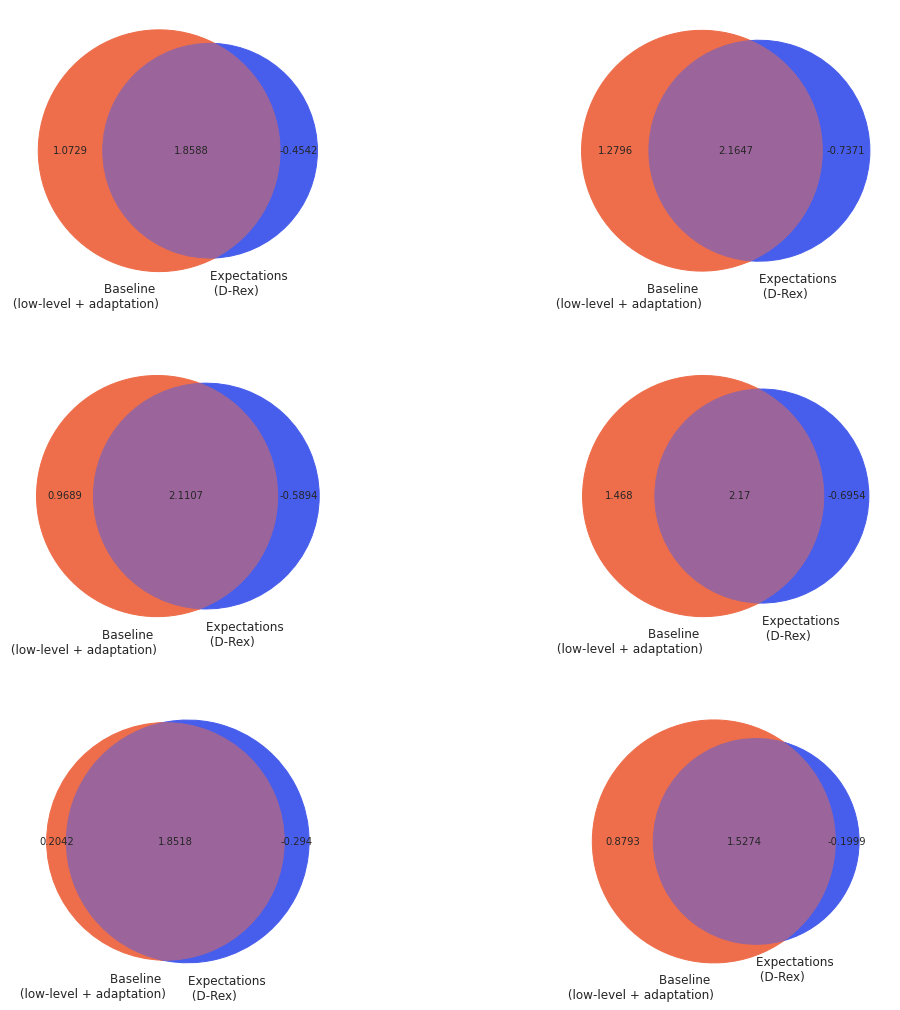

In [61]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (cv mean)')
        cond_B = cond_names.index('prediction (cv mean)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (cv mean)')

        A = img[:,:,:,cond_A][frontal]
        B = img[:,:,:,cond_B][frontal]
        AuB = img[:,:,:,cond_AuB][frontal]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-5000:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

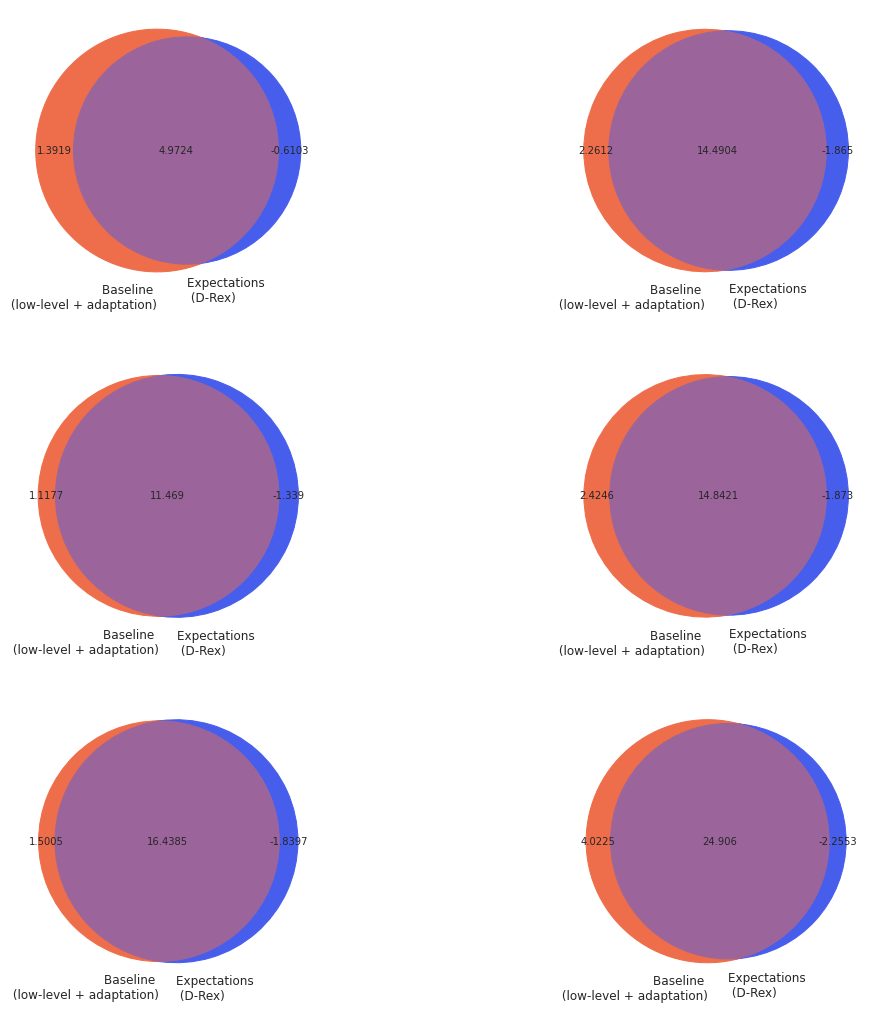

In [62]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (cv mean)')
        cond_B = cond_names.index('prediction (cv mean)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (cv mean)')

        A = img[:,:,:,cond_A][auditory]
        B = img[:,:,:,cond_B][auditory]
        AuB = img[:,:,:,cond_AuB][auditory]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-5000:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

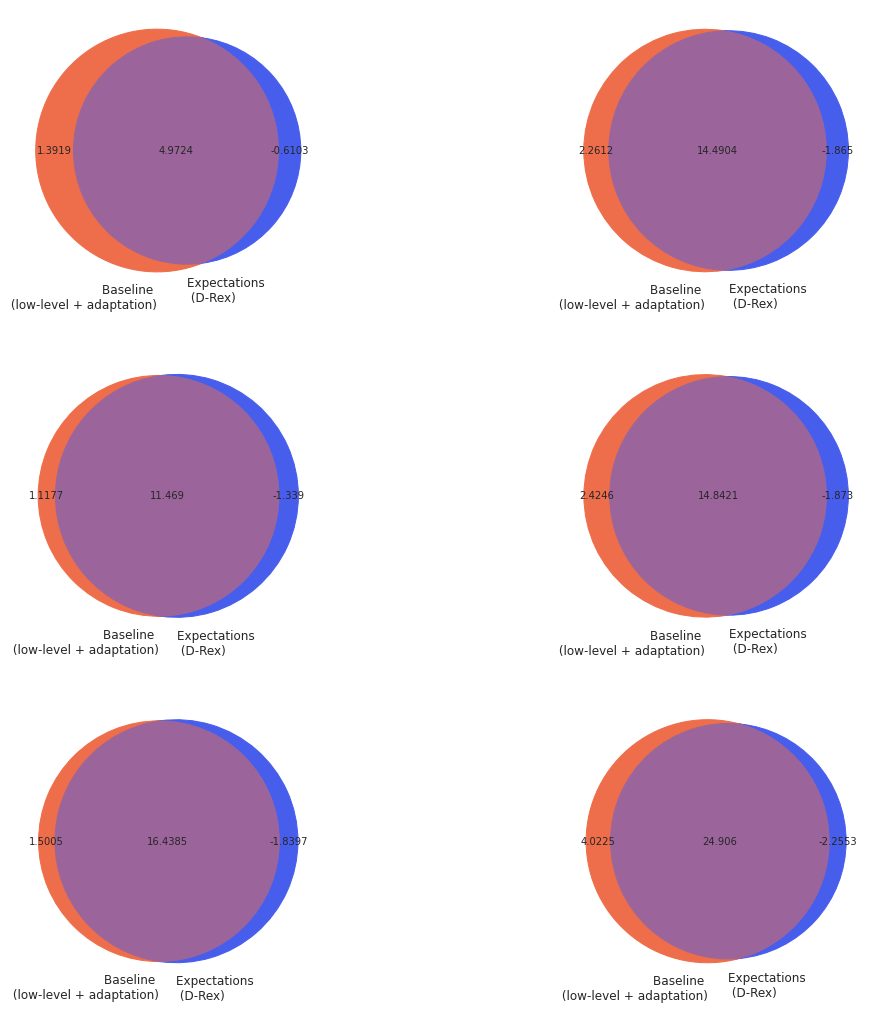

In [63]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (cv mean)')
        cond_B = cond_names.index('prediction (cv mean)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (cv mean)')

        A = img[:,:,:,cond_A][auditory]
        B = img[:,:,:,cond_B][auditory]
        AuB = img[:,:,:,cond_AuB][auditory]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-5000:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

In [64]:
# other amount of voxels

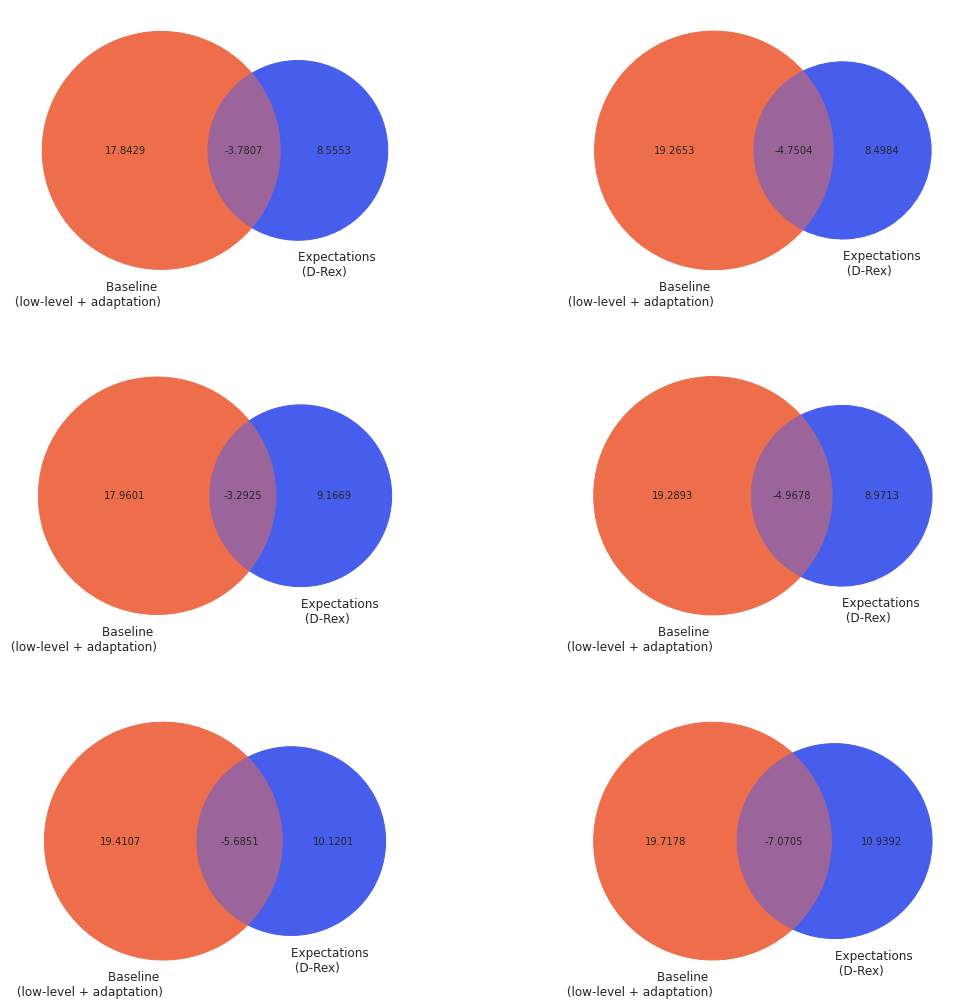

In [65]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))
 
lbls=['Baseline \n (low-level + adaptation)','Expectations \n (D-Rex)']
hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (non-cv)')
        cond_B = cond_names.index('prediction (non-cv)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (non-cv)')

        A = img[:,:,:,cond_A][frontal]
        B = img[:,:,:,cond_B][frontal]
        AuB = img[:,:,:,cond_AuB][frontal]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-800:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

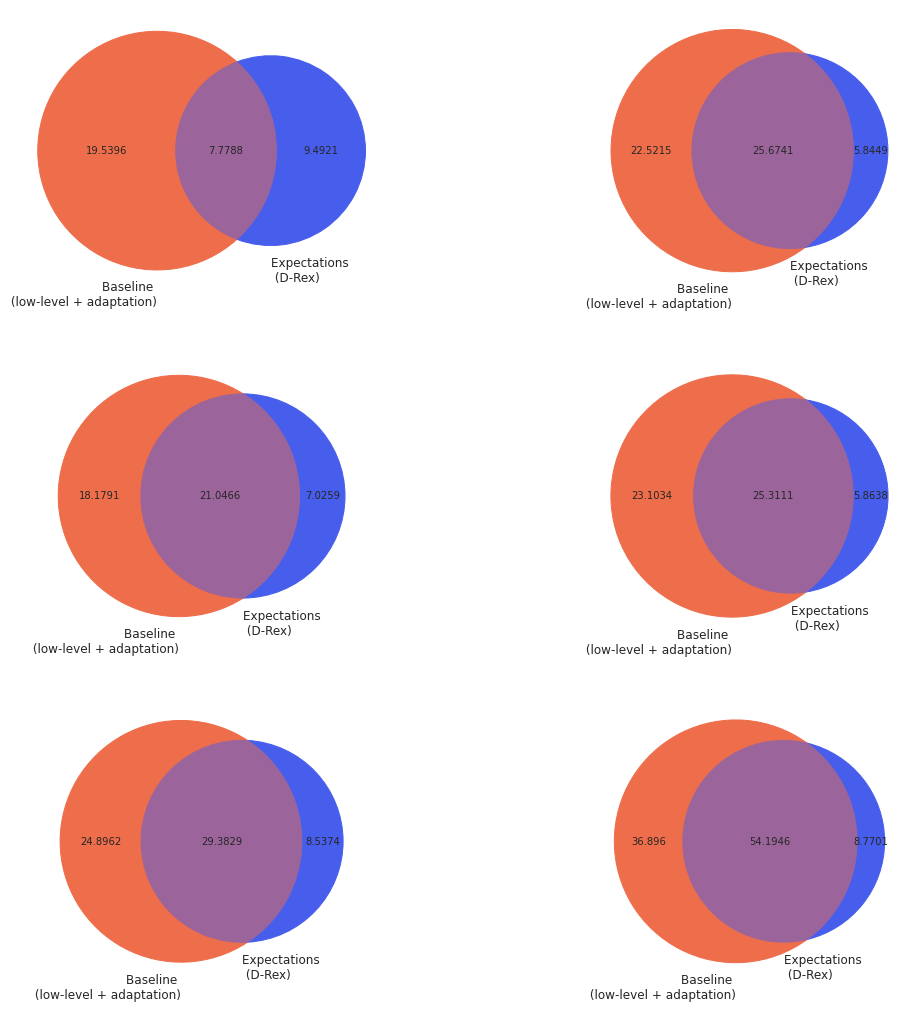

In [66]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (non-cv)')
        cond_B = cond_names.index('prediction (non-cv)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (non-cv)')

        A = img[:,:,:,cond_A][auditory]
        B = img[:,:,:,cond_B][auditory]
        AuB = img[:,:,:,cond_AuB][auditory]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-800:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

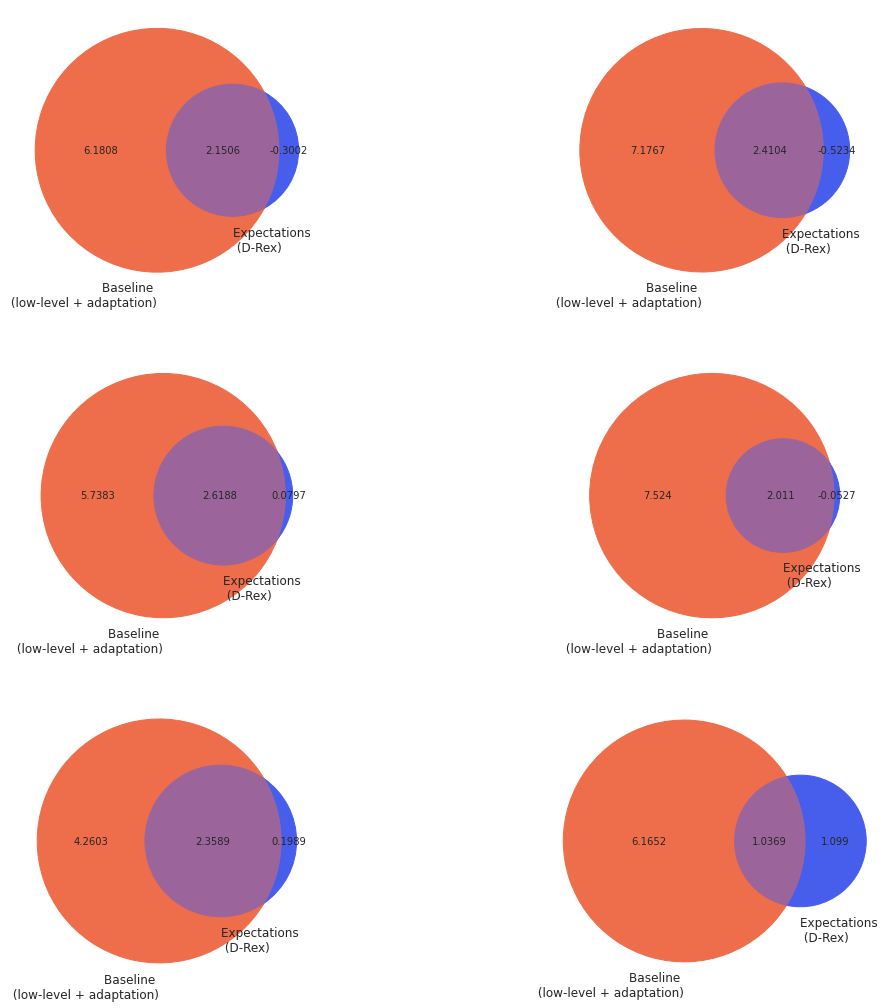

In [67]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (cv mean)')
        cond_B = cond_names.index('prediction (cv mean)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (cv mean)')

        A = img[:,:,:,cond_A][frontal]
        B = img[:,:,:,cond_B][frontal]
        AuB = img[:,:,:,cond_AuB][frontal]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-800:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

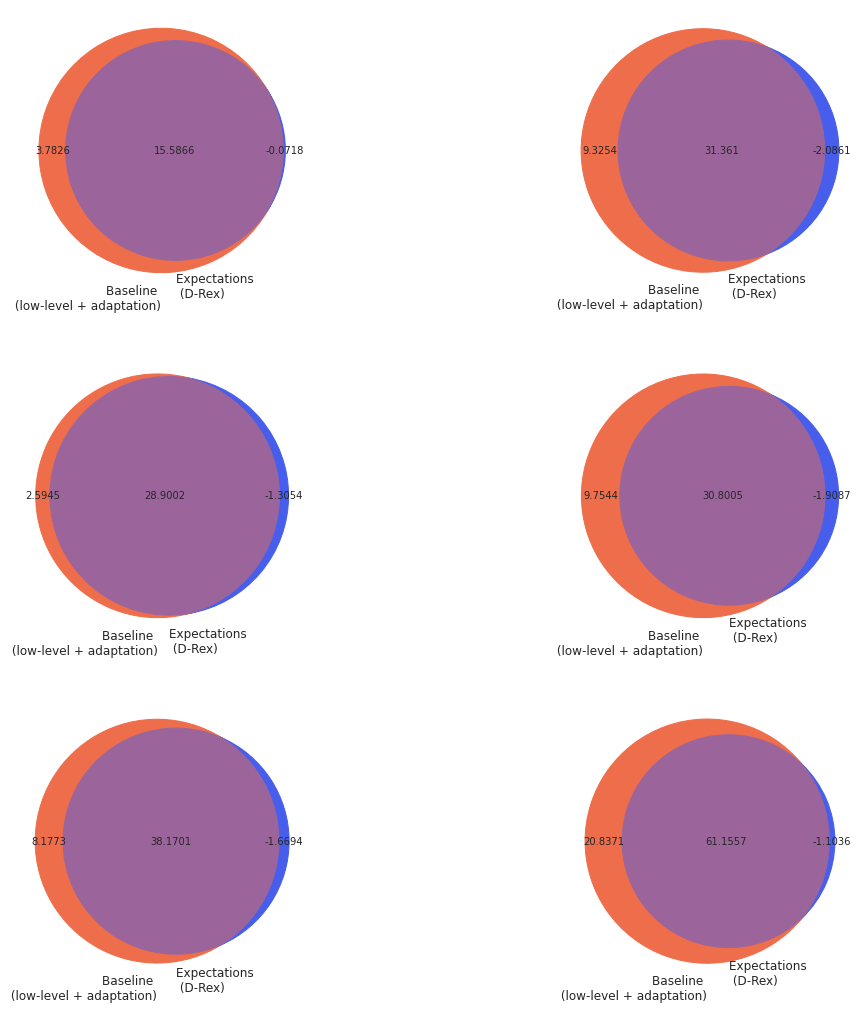

In [68]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (cv mean)')
        cond_B = cond_names.index('prediction (cv mean)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (cv mean)')

        A = img[:,:,:,cond_A][auditory]
        B = img[:,:,:,cond_B][auditory]
        AuB = img[:,:,:,cond_AuB][auditory]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-800:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

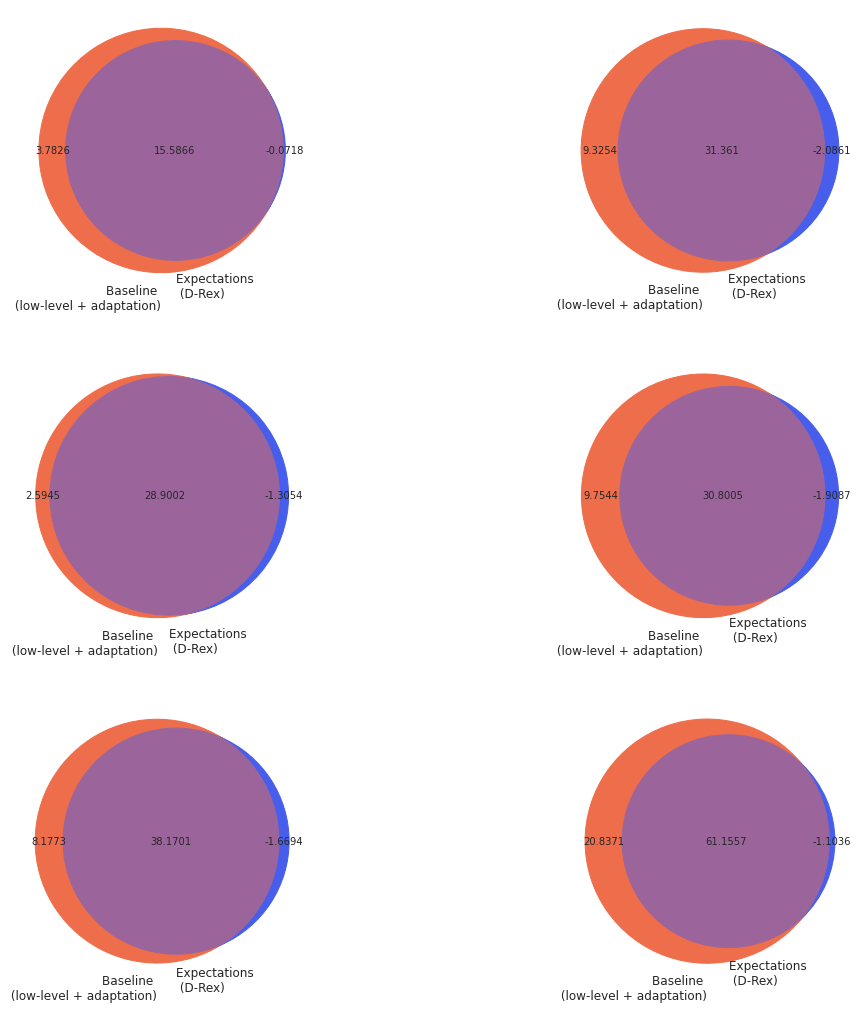

In [69]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (cv mean)')
        cond_B = cond_names.index('prediction (cv mean)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (cv mean)')

        A = img[:,:,:,cond_A][auditory]
        B = img[:,:,:,cond_B][auditory]
        AuB = img[:,:,:,cond_AuB][auditory]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-800:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

In [ ]:
# other amount of voxels

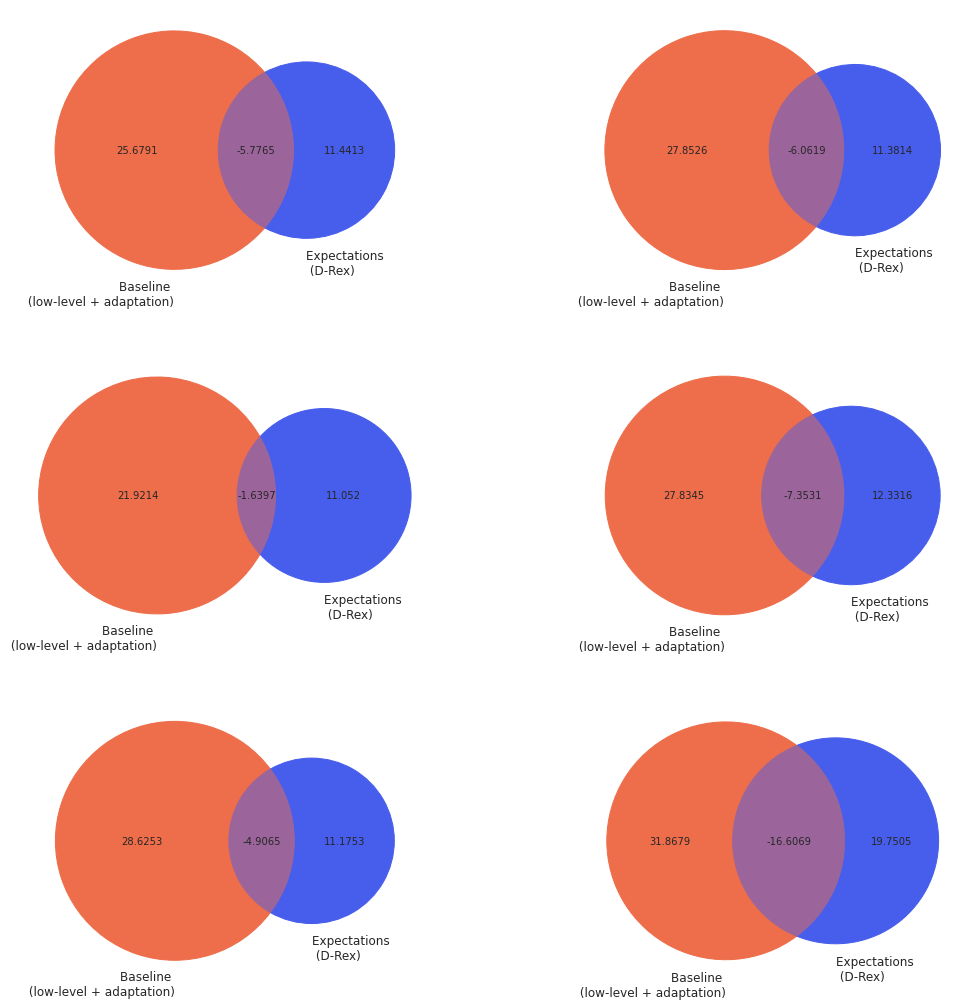

In [70]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))
 
lbls=['Baseline \n (low-level + adaptation)','Expectations \n (D-Rex)']
hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (non-cv)')
        cond_B = cond_names.index('prediction (non-cv)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (non-cv)')

        A = img[:,:,:,cond_A][frontal]
        B = img[:,:,:,cond_B][frontal]
        AuB = img[:,:,:,cond_AuB][frontal]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-100:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

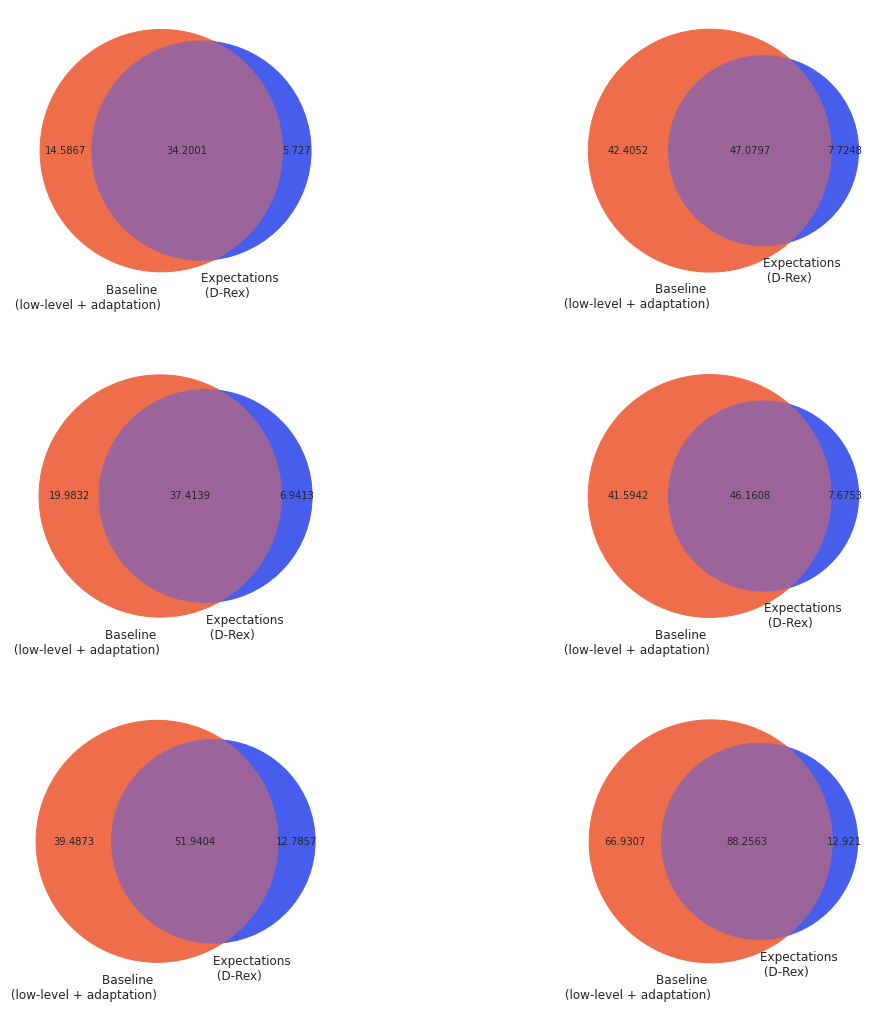

In [71]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (non-cv)')
        cond_B = cond_names.index('prediction (non-cv)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (non-cv)')

        A = img[:,:,:,cond_A][auditory]
        B = img[:,:,:,cond_B][auditory]
        AuB = img[:,:,:,cond_AuB][auditory]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-100:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

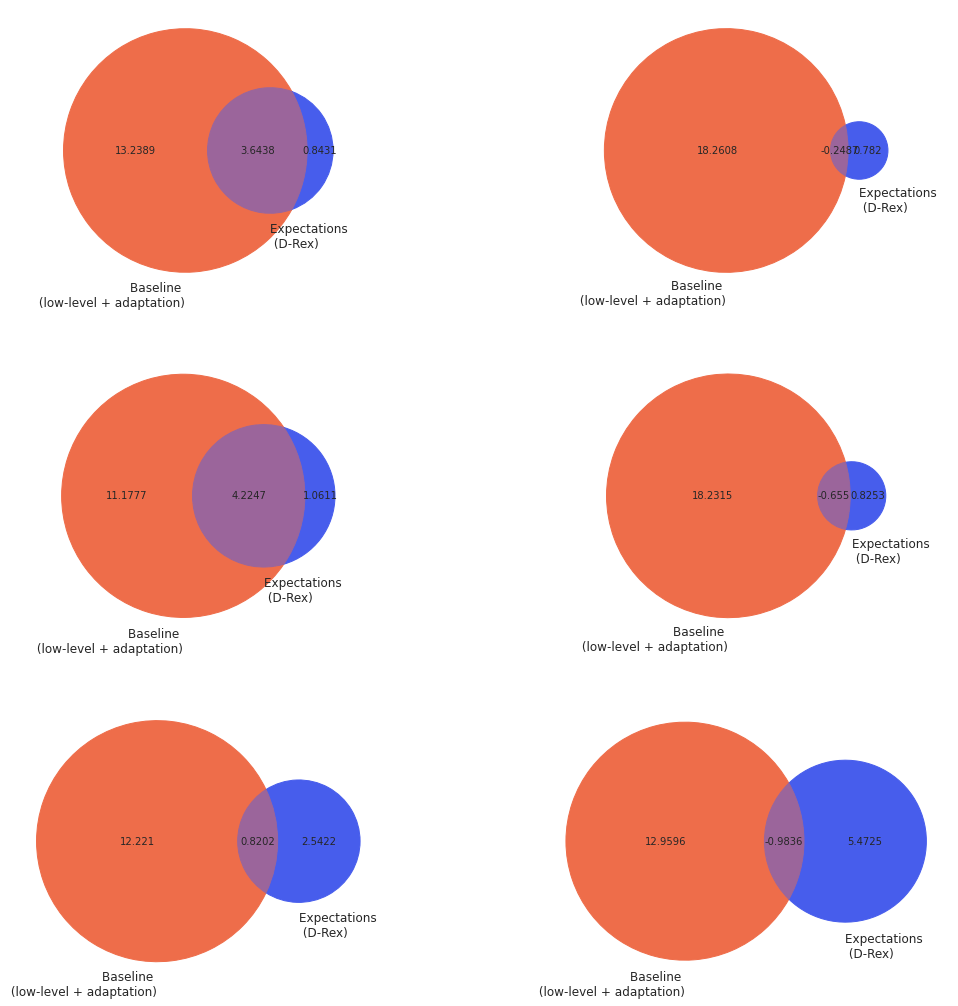

In [72]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (cv mean)')
        cond_B = cond_names.index('prediction (cv mean)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (cv mean)')

        A = img[:,:,:,cond_A][frontal]
        B = img[:,:,:,cond_B][frontal]
        AuB = img[:,:,:,cond_AuB][frontal]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-100:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

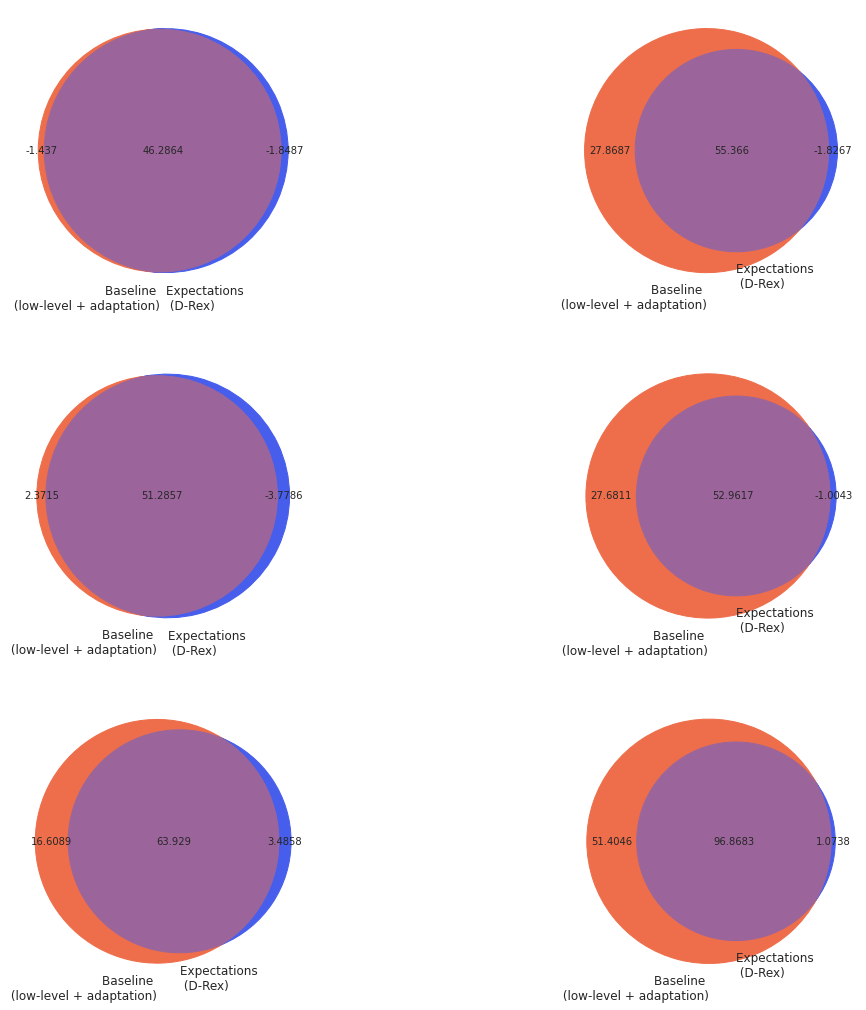

In [73]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (cv mean)')
        cond_B = cond_names.index('prediction (cv mean)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (cv mean)')

        A = img[:,:,:,cond_A][auditory]
        B = img[:,:,:,cond_B][auditory]
        AuB = img[:,:,:,cond_AuB][auditory]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-100:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

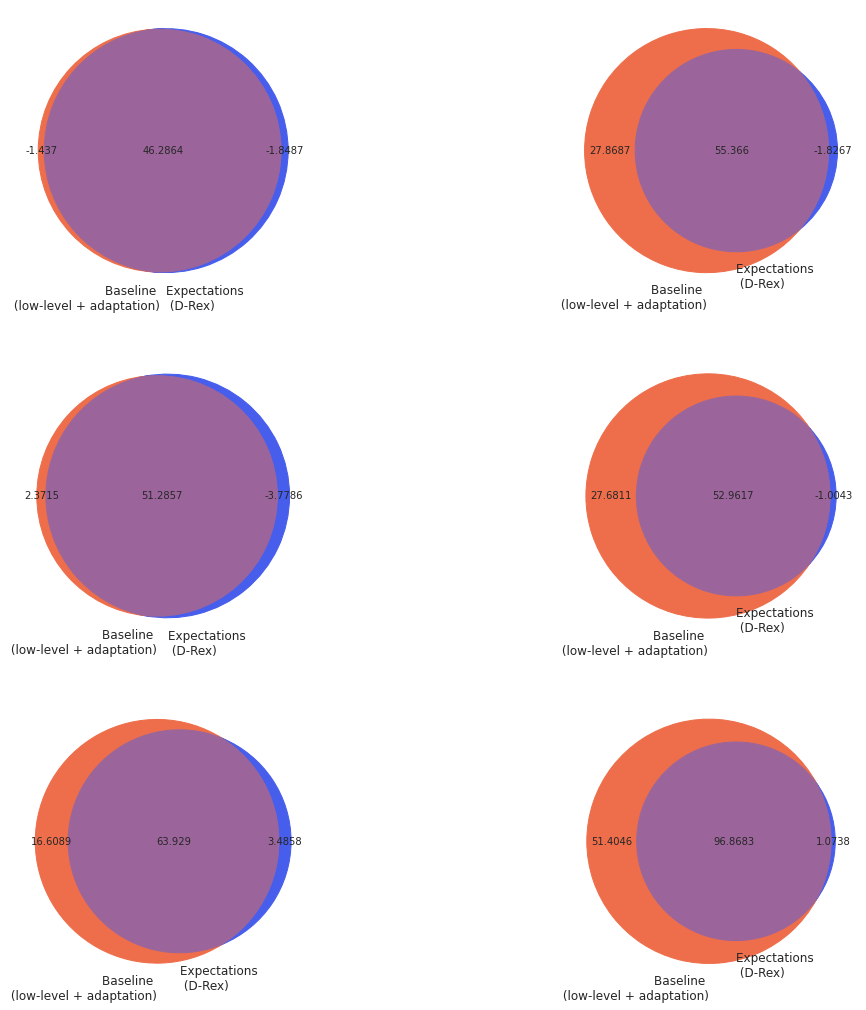

In [74]:
fig, ax = plt.subplots(3,2, figsize=(18, 18))

hemispheres = ['LH', 'RH']
depths = [1, 2, 3]

for i in range(len(hemispheres)):
#     print(i, hemispheres[i])
    
    for d in range(len(depths)):
#         print(d, depths[d])
        
        head, img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(1, 1), vmpfn(hemispheres[i], depths[d])))

        cond_A = cond_names.index('base_U_adaptation (cv mean)')
        cond_B = cond_names.index('prediction (cv mean)')
        cond_AuB = cond_names.index('base_U_adaptation_U_prediction (cv mean)')

        A = img[:,:,:,cond_A][auditory]
        B = img[:,:,:,cond_B][auditory]
        AuB = img[:,:,:,cond_AuB][auditory]
        
        # get bax amongst models within voxel
        grandmax = np.vstack((A,B, AuB)).max(axis=0)
        maxidx = np.argsort(grandmax)[-100:]

        A = A[maxidx]
        B = B[maxidx]
        AuB = AuB[maxidx]

        fg = plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True), ax=ax[d, i],
                                            labels=lbls,avgfun=np.mean, alpha=1)
        fg = pimpcollors_venn2(fg)

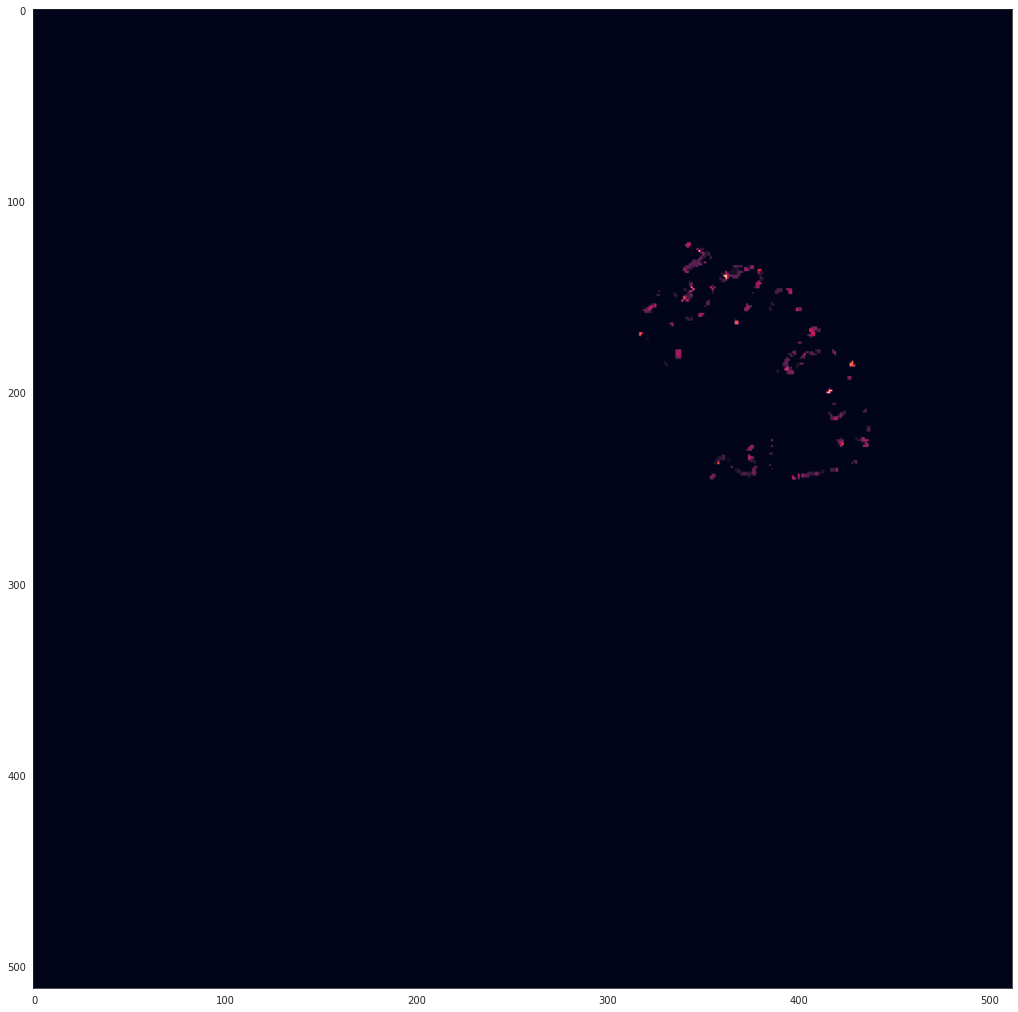

In [40]:
# sellect condtion
img_oi = img[:,:,:,cond_idx]

# # for plotting
# new_front = np.zeros(img_oi.shape)
# new_aud = np.zeros(img_oi.shape)

# define only for frontal and auditory
img_oi_front = img_oi[frontal]
img_oi_aud = img_oi[auditory]

# # set plotting
# new_front[frontal] = img_oi_front
# new_aud[auditory] = img_oi_aud

# fig, ax = plt.subplots(figsize=(18, 18))

# ax.imshow(new_front[:,:,300])

### reconstruction of image
(for testing)

In [27]:
# import bvbabel

# mridat_dir = '/media/jorvhar/Data1/MRIData/PreProc'
# vtc_dir = '/media/jorvhar/New Volume1/vtcs' # adviced to put vtc's on a (nvme) ssd while running analyses
# pp_dir = lambda pp, ses : f'S{pp:02d}_SES{ses}'
# betas_dir = 'Betas'

# # tonotopy and mask filenames
# tonotopy_vmp = 'prf_permutations_for_S2.vmp'
# mask_fn = 'brainmask.msk'

# # chunking settings
# chucksize = 50000   # msk[0].shape[0]
# # pp = 1
# ses = 2

# # fn lambda
# fn = lambda pp, ses, run : f'S{pp:02d}_SES{ses}_run{run}_FMR_SCSTBL_3DMAS_THPGLMF7c_TOPUP.vtc'

# # create full path
# mskpath = join(mridat_dir, pp_dir(pp,1), mask_fn)
# vmppath = join(mridat_dir, pp_dir(pp,1), betas_dir, tonotopy_vmp)

# # load full mask and convert to indeces
# _, msk = bvbabel.msk.read_msk(mskpath)
# msk = np.where(msk)
# # devide the mask in chucks based on our chucksize
# chunked_msk = vtc.chuck_msk(msk, chucksize)

# # load vmp image
# vmp_head, vmp_img = bvbabel.vmp.read_vmp(vmppath)

In [36]:
def set_map(mapname, mapthreshold=1.65, mapupperthreshold=8.0):
    FDRTableInfo = np.array([], dtype=np.float64)
    FDRTableInfo.shape = (0,3)
    returnmap = {'TypeOfMap': 1,
     'MapThreshold': mapthreshold,
     'UpperThreshold': mapupperthreshold,
     'MapName': mapname,
     'RGB positive min': np.array([255,   0,   0], dtype=np.uint8),
     'RGB positive max': np.array([255, 255,   0], dtype=np.uint8),
     'RGB negative min': np.array([255,   0, 255], dtype=np.uint8),
     'RGB negative max': np.array([  0,   0, 255], dtype=np.uint8),
     'UseVMPColor': 0,
     'LUTFileName': '<default>',
     'TransparentColorFactor': 1.0,
     'ClusterSizeThreshold': 50,
     'EnableClusterSizeThreshold': 0,
     'ShowValuesAboveUpperThreshold': 1,
     'DF1': 249,
     'DF2': 1,
     'ShowPosNegValues': 3,
     'NrOfUsedVoxels': 45555,
     'SizeOfFDRTable': 0,
     'FDRTableInfo': FDRTableInfo,
     'UseFDRTableIndex': 0}
    return(returnmap)

In [37]:
lookup = np.array([[0.33, 0.33,0.34],
                [0.264, 0.264,0.472],
                [0.198, 0.198,0.604],
                [0.132, 0.132,0.736],
                [0.066, 0.066,0.868],
                [0, 0,1],
                [0.1225, 0,0.8775],
                [0.245,0,0.755],
                [0.3675,0,0.6325],
                [0.49,0,0.51],
                [0.34,0.33,0.33],
                [0.472,0.264,0.264],
                [0.604,0.198,0.198],
                [0.736,0.132,0.132],
                [0.868,0.066,0.066],
                [1,0,0],
                [0.8775,0,0.1225],
                [0.755,0,0.245],
                [0.6325,0,0.3675],
                [0.51,0,0.49]])

In [38]:
lookup = np.array([[1,0,0],
              [0.833333333333333,0.166666666666667,0],
              [0.666666666666667,0.333333333333333,0],
              [0.5,0.5,0],
              [0.25,0.75,0],
              [0,1,0],
              [0,0.75,0.25],
              [0,0.5,0.5],
              [0,0.333333333333333,0.666666666666667],
              [0,0.166666666666667,0.833333333333333],
              [0,0,1],
              [0.166666666666667,0,0.833333333333333],
              [0.333333333333333,0,0.666666666666667],
              [0.5,0,0.5],
              [0.833333333333333,0,0.166666666666667],
              [0.666666666666667,0,0.333333333333333],
              [0.333,0.333,0.333],
              [0.1665,0.1665,0.6665],
              [0.6665,0.1665,0.1665],
              [0.1665,0.6665,0.1665]])
    
def closest_row(lookup, coord):
    """quick function so search for the closest coordinate in the lookup table
    then convert this to the -10 +10 range of brainvoyager"""
    lookup = np.array(lookup)
    coords = np.array(coord)
    bv_value = np.concatenate((np.arange(1,11,1), np.arange(-1,-11,-1)))
    distances = np.linalg.norm(lookup[np.newaxis, :, :] - coords[:, np.newaxis, :], axis=2)
    return bv_value[np.argmin(distances, axis=1)]

In [39]:
# set theory calculations
pred_unique = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] - scores['base_U_adaptation']['non-cv']['raw_scores']
base_unique = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] - scores['prediction']['non-cv']['raw_scores']
common_part = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] - pred_unique - base_unique

# take full matrix and stack/normalize
full_mat = np.stack((pred_unique, common_part, base_unique)) # stack 3 parts of sets
full_mat = full_mat.clip(min=0) / full_mat.clip(min=0).sum(axis=0)  # normalize matrix

# get -10 10 range
map_val = closest_row(lookup, full_mat.transpose())

# so some sellection
sellection = scores['base_U_adaptation_U_prediction']['non-cv']['correlation'] < 0.05
map_val[sellection] = 0

In [40]:
## stranslate data to vmp

# pp = 2
nr_models = 1

# filenames
mridat_dir = '/media/jorvhar/Data1/MRIData/PreProc'
pp_dir = lambda pp, ses : f'S{pp:02d}_SES{ses}'
betas_dir = 'Betas'

# tonotopy and mask filenames
tonotopy_vmp = 'prf_permutations_for_S2.vmp'

# load vmp image
score_vmp_head, vmp_img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(pp,1), betas_dir, tonotopy_vmp))
score_vmp_full = np.zeros((list(vmp_img.shape[:-1]) + [nr_models * 2]))
score_vmp_head['NrOfSubMaps'] = nr_models
score_vmp_head['Map'] = []

# full map
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = map_val
score_vmp_full[:,:,:,0] = score_vmp
score_vmp_head['Map'].append(set_map('pred', mapthreshold=0, mapupperthreshold=10))

bvbabel.vmp.write_vmp('/media/jorvhar/Data1/MRIData/PreProc/S0{}_SES1/Betas/map2023-1.vmp'.format(pp),score_vmp_head, score_vmp_full)

In [41]:
sellection = scores['base_U_adaptation_U_prediction']['non-cv']['correlation'] < 0.035
full_mat[:,sellection] = 0

np.round(full_mat[0,:] * 10)  # prediction map
np.round(full_mat[1,:] * 10)  # common map
np.round(full_mat[2,:] * 10)  # baseline map


array([8., 8., 5., ..., 0., 0., 7.])

In [42]:
## stranslate data to vmp

# pp = 1
nr_models = 3

# filenames
mridat_dir = '/media/jorvhar/Data1/MRIData/PreProc'
pp_dir = lambda pp, ses : f'S{pp:02d}_SES{ses}'
betas_dir = 'Betas'

# tonotopy and mask filenames
tonotopy_vmp = 'prf_permutations_for_S2.vmp'

# load vmp image
score_vmp_head, vmp_img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(pp,1), betas_dir, tonotopy_vmp))
score_vmp_full = np.zeros((list(vmp_img.shape[:-1]) + [nr_models * 2]))
score_vmp_head['NrOfSubMaps'] = nr_models
score_vmp_head['Map'] = []

# full map
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = np.round(full_mat[0,:] * 10)
score_vmp_full[:,:,:,0] = score_vmp
score_vmp_head['Map'].append(set_map('pred', mapthreshold=0, mapupperthreshold=10))

# full map
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = np.round(full_mat[1,:] * 10)
score_vmp_full[:,:,:,1] = score_vmp
score_vmp_head['Map'].append(set_map('common', mapthreshold=0, mapupperthreshold=10))

# full map
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = np.round(full_mat[2,:] * 10)
score_vmp_full[:,:,:,2] = score_vmp
score_vmp_head['Map'].append(set_map('baseline', mapthreshold=0, mapupperthreshold=10))

bvbabel.vmp.write_vmp('/media/jorvhar/Data1/MRIData/PreProc/S0{}_SES1/Betas/map1234.vmp'.format(pp),score_vmp_head, score_vmp_full)

In [43]:
## stranslate data to vmp

# pp = 1
nr_models = 6
multiplyer = 50 # for floating point errros, use multiplyer

# filenames
mridat_dir = '/media/jorvhar/Data1/MRIData/PreProc'
pp_dir = lambda pp, ses : f'S{pp:02d}_SES{ses}'
betas_dir = 'Betas'

# tonotopy and mask filenames
tonotopy_vmp = 'prf_permutations_for_S2.vmp'

# load vmp image
score_vmp_head, vmp_img = bvbabel.vmp.read_vmp(join(mridat_dir, pp_dir(pp,1), betas_dir, tonotopy_vmp))
score_vmp_full = np.zeros((list(vmp_img.shape[:-1]) + [nr_models * 2]))
score_vmp_head['NrOfSubMaps'] = nr_models * 2
score_vmp_head['Map'] = []

#############################
# FIRST DO EVERYTHING NON-CV
#############################

# set theory calculations
pred_unique = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] - scores['base_U_adaptation']['non-cv']['raw_scores']
base_unique = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] - scores['prediction']['non-cv']['raw_scores']
common_part = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] - pred_unique - base_unique

# base model
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['base_U_adaptation']['non-cv']['raw_scores'] * multiplyer
score_vmp_full[:,:,:,0] = score_vmp
score_vmp_head['Map'].append(set_map('base_U_adaptation (non-cv)', mapthreshold=0.0001, mapupperthreshold=0.25))

# pred model
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['prediction']['non-cv']['raw_scores'] * multiplyer
score_vmp_full[:,:,:,1] = score_vmp
score_vmp_head['Map'].append(set_map('prediction (non-cv)', mapthreshold=0.0001, mapupperthreshold=0.25))

# full model
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] * multiplyer
score_vmp_full[:,:,:,2] = score_vmp
score_vmp_head['Map'].append(set_map('base_U_adaptation_U_prediction (non-cv)', mapthreshold=0.0001, mapupperthreshold=0.25))

# base unique
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = base_unique * multiplyer
score_vmp_full[:,:,:,3] = score_vmp
score_vmp_head['Map'].append(set_map('base_unique (non-cv)', mapthreshold=0.0001, mapupperthreshold=0.25))

# pred unique
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = pred_unique * multiplyer
score_vmp_full[:,:,:,4] = score_vmp
score_vmp_head['Map'].append(set_map('pred_unique (non-cv)', mapthreshold=0.0001, mapupperthreshold=0.25))

# shared
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = common_part * multiplyer
score_vmp_full[:,:,:,5] = score_vmp
score_vmp_head['Map'].append(set_map('base_N_adaptation_N_prediction (non-cv)', mapthreshold=0.0001, mapupperthreshold=0.25))


#####################################
# do same on cross validated results
#####################################

# set theory calculations
pred_unique = scores['base_U_adaptation_U_prediction']['raw_scores']['mean'] - scores['base_U_adaptation']['raw_scores']['mean']
base_unique = scores['base_U_adaptation_U_prediction']['raw_scores']['mean'] - scores['prediction']['raw_scores']['mean']
common_part = scores['base_U_adaptation_U_prediction']['raw_scores']['mean'] - pred_unique - base_unique

# base model
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['base_U_adaptation']['raw_scores']['mean'] * multiplyer
score_vmp_full[:,:,:,6] = score_vmp
score_vmp_head['Map'].append(set_map('base_U_adaptation (cv mean)', mapthreshold=0.0001, mapupperthreshold=0.25))

# pred model
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['prediction']['raw_scores']['mean'] * multiplyer
score_vmp_full[:,:,:,7] = score_vmp
score_vmp_head['Map'].append(set_map('prediction (cv mean)', mapthreshold=0.0001, mapupperthreshold=0.25))

# full model
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['base_U_adaptation_U_prediction']['raw_scores']['mean'] * multiplyer
score_vmp_full[:,:,:,8] = score_vmp
score_vmp_head['Map'].append(set_map('base_U_adaptation_U_prediction (cv mean)', mapthreshold=0.0001, mapupperthreshold=0.25))

# base unique
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = base_unique * multiplyer
score_vmp_full[:,:,:,9] = score_vmp
score_vmp_head['Map'].append(set_map('base_unique (cv mean)', mapthreshold=0.0001, mapupperthreshold=0.25))

# pred unique
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = pred_unique * multiplyer
score_vmp_full[:,:,:,10] = score_vmp
score_vmp_head['Map'].append(set_map('pred_unique (cv mean)', mapthreshold=0.0001, mapupperthreshold=0.25))

# shared
score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = common_part * multiplyer
score_vmp_full[:,:,:,11] = score_vmp
score_vmp_head['Map'].append(set_map('base_N_adaptation_N_prediction (cv mean)', mapthreshold=0.0001, mapupperthreshold=0.25))

bvbabel.vmp.write_vmp('/media/jorvhar/Data1/MRIData/PreProc/S0{}_SES2/Betas/session2.vmp'.format(pp),score_vmp_head, score_vmp_full)

In [44]:
baseidx = np.where(map_val == 7)[0][100] # index pure baseline
mixidx = np.where(map_val == -1)[0][100] # fully mixed
predidx = np.where(map_val == -6)[0][0] # pure prediction
predbaseidx = np.where(map_val == 10)[0][100] # pred + adapt


### variance partitioning

In [46]:
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn3
import numpy as np 

def two_way_varpart(A,B,AuB,correct_R2s=True,return_sep=True):
    """2-way variance partitioning. Handles scalars (single R2s) and vectors (multiple R2s).
    
    By default, this function implements a correction to handle cross-validated R2s. 
    That is, estimates and adds the smallest bias vector (in an L2-sense) such that the 
    set theoretic equations yield no inconsistent results. See De Heer, Huth, et al. 
    
    For info, see:
    - de Heer, Huth, et al. (2017) Journal of Neuroscience, 37(27), 6539-6557.

    In:
    positional args: 
    - (A,B,AuB): floats or np.array, shape(n_resp)
        R2 values for GLMs with each feature space, and the union of them. 
    - return_sep: bool (Default: True)
        if True, returns separate variable for each partition (i.e. as tuple of scalars/vectors)  
        If False, returns values in vectorised form (i.e. vector of scalars / matrix of row-vectors)
    -correct_R2s: Bool (Default: True)
        Implement correction to avoid impossible values.
    
    Out:
    - 6 separate variables for each (adjusted) input R2 and each partition 
        if return_sep=True
    OR
    - 1 variable for all (adjusted) input R2s and partitions 
        (6-dimensional vector if input is scalar; (6 x n_resp) dim matrix if input is vector)
    order of output:
    (A,B,C, AuB, # input R2s (adjusted values if needed)
     A*,B*, AnB) # output partitions
    
    -------
    MH 2020
    -------
    """
    eqs=np.array([[0,-1,1],  # A_ =  AuB - B 
                  [-1,0,1],  # B_ =  AuB - A 
                  [1,1,-1]]) # AnB=  A+B -AuB 
    all_ABAuB=np.vstack((A,B,AuB))
    all_ABAuB[all_ABAuB<0]=0 # ignore negative values 
    
    # estimate biases (still iterative over responses...)
    all_biases=np.zeros_like(all_ABAuB)
    if correct_R2s:
        for vox_i, ABAuB in enumerate(all_ABAuB.T):
            all_biases[:,vox_i]=_est_bias_2wayVP(ABAuB[0],ABAuB[1],ABAuB[2])
        
    all_ABAuB_adjusted=all_ABAuB+all_biases
    all_A_B_AnB=eqs.dot(all_ABAuB_adjusted)

    if return_sep: # if return values as separate variables (i.e. as tuple of scalars/vectors)
        return(all_ABAuB_adjusted[0],all_ABAuB_adjusted[1],all_ABAuB_adjusted[2],
           all_A_B_AnB[0],all_A_B_AnB[1],all_A_B_AnB[2])
    else: # if return vectorised form 
        return(np.vstack((all_ABAuB_adjusted,all_A_B_AnB)))

def _est_bias_2wayVP(A,B,AuB):
    """estimate bias vector for A*,B* and AnB in 2 way variance partitioning.
    in:
    - A,B,AuB: floats
        R2 for A B and AuB feauterespaces
    returns:
    -b123: bias vector for A,B,AnB
    """
    def obj(x):
        return(np.linalg.norm(x)) #  l2 norm 

    def c1(x): # A_ >=0; in other words, AuB+x[2] - B+x[1] >=0
        return((AuB+x[2]) - (B+x[1]))

    def c2(x): # B_ >=0; in other words, AuB+x[2] - A+x[0] >=0
        return((AuB+x[2]) - (A+x[0]))

    def c3(x): # AnB >=0; in other words, (A+x[0]) + (B+x[1]) - (AuB+x[2])] >=0
        return((A+x[0]) + (B+x[1]) - (AuB+x[2]))
    cons=(
        {'type':'ineq','fun':c1},
        {'type':'ineq','fun':c2},
        {'type':'ineq','fun':c3},
    )
    res=minimize(obj,np.random.rand(3)*.001,constraints=cons,bounds=((None,0),)*3,)
    if not res.success: 
        print('initial faillure... trying harder......')
        res = minimize(obj,np.random.rand(3)*.001,constraints=cons,bounds=((None,0),)*3,
                      method='SLSQP',options={'maxiter':999})
        if res.success: return(res.x)
        else: # if still not, check what's happening 
            print('A',A);print('B:',B);print('AuB',AuB)
            set_trace() # to be commented later on
            return(np.nan(3))
    else: 
        return(res.x)
def _est_bias_3wayVP(A,B,C,AuB,AuC,BuC,AuBuC, only_overlap=True):
    """estimate bias vector for A*,B*,C* and AnB,AnC,BnC,AnBnC in 3 way variance partitioning.
    in:
    - A,B,C,AuB,AuC,BuC,AuBuC: floats
        R2 for A B and AuB feauterespaces
    returns:
    -b123: bias vector for A,B,C,AuB,AuC,BuC,AuBuC
    """
    def obj(x):
        return(np.linalg.norm(x)) #  l2 norm 
    
    def c1(x): # A*  = AuBuC - BuC  
        return((AuBuC+x[6]) - (BuC+x[5]))
    def c2(x): # B* >=0; in other words:  (AuBuC+x[6]) - (AuC+x[4]) >=0
        return((AuBuC+x[6]) - (AuC+x[4]))
    def c3(x): # C*  >=0; in other words AuBuC - AuB
        return((AuBuC+x[6]) - (AuB+x[3]))
    def c4(x):# AnB*= AuC + BuC - C - AuBuC
        return((AuC+x[4]) + (BuC+x[5]) - (C+x[2])- (AuBuC+x[6]))
    def c5(x):# AnC* = AuB + BuC - B - AuBuC
        return((AuB+x[3]) + (BuC+x[5]) - (B+x[1])- (AuBuC+x[6]))
    def c6(x):# BnC*= AuB + AuC - A - AuBuC
        return((AuB+x[3]) + (AuC+x[4]) - (A+x[0])- (AuBuC+x[6]))
    def c7(x):# AnBnC =  AuBuC + A+B+C - AuB - AuC -BuC
        return((AuBuC+x[6]) + (A+x[0]) + (B+x[1]) + (C+x[2]) -
               (AuB+x[3]) - (AuC+x[4]) - (BuC+x[5]))
    
    # define constraintes: all funcs >=0
    np.random.seed(123)
    if only_overlap == True: 
        cons=tuple({'type':'ineq','fun':c} for c in [c4,c5,c6,c7])
        res=minimize(obj,np.random.rand(7)*-.0001,constraints=cons,bounds=((None,0),)*7,)
    else: 
        cons=tuple({'type':'ineq','fun':c} for c in [c1,c2,c3,c4,c5,c6,c7])   
        res=minimize(obj,np.random.rand(7)*-.0001,constraints=cons,bounds=((None,0),)*7,)
    
    if not res.success: 
        print('initial faillure... trying harder......')
        res = minimize(obj,np.random.rand(7)*-.0001,constraints=cons,bounds=((0,None),)*7,
                      method='SLSQP',options={'maxiter':999})
        if res.success: return(res.x)
        else: # if still not, check what's happening 
            print('A',A);print('B:',B);print('AuB',AuB)
            set_trace() # to be commented later on
            return(np.nan(3))
    else: 
        return(res.x)


In [29]:
def plot_2way_varpartven(varpartres,avgfun=np.mean,mask=None,formatter=None,
                        labels=['A \n features', 'B \n features'],
                         newfig=False,ax=None, alpha=0.5):
    """wrapper function to plot results coming from `two_way_varpart` function.
    
    in: 
    - varpartres (tuple)
        tuple of res from `three_way_varpart`:
        with order:
              (A, B, AuB,,   # input R2s (adjusted values if needed)
              A*,B*,C*,AnB*,AnC*,BnC*,AnBnC) # output partitions (index 7 and beyond)    
              7, 8, 9, 10,   11,  12, 13
    - avgfun: callable (default: np.mean)
        if you average over small number of responses, maybe use median?
    - get_res: None | int/float | callable 
        which result to get. can be either a callable (e.g. mean function) or an index (specific voxel)
        defaults to mean if None
    - labels: Sequenceof 3 strings
        labels of the three venns
    - formatter: callable | None
        function doing the label formatting. defaults to converting to % and rouning
    
    returns:
    -figure: mpl figure 
    """
    if not formatter: formatter=lambda x: "{}".format(round(x*100,4))
    get_rez=avgfun if (mask is None) else lambda x: avgfun(x[mask])            
    if newfig: plt.figure()
    varpartrez_orderd=tuple(varpartres[vp_i] for vp_i in [3, 4, 5])  # check this
    fig= venn2(subsets=tuple(get_rez(vp) for vp in varpartrez_orderd),
               set_labels=labels,subset_label_formatter=formatter,ax=ax, alpha=alpha)
    return(fig)

def organise_3way_varpartres(vpres_in,lbls=['Syn','Sem','Lex'],ignorenegative=True):
    """From tuple of 3-way varpartres, make a dict with clear labels.
    
    
    In: 
    - vpres_in: Tuple (np.array,np.array,...)
        14 arrays; output from ``three_way_varpart``
    - lbls: List / Sequence of strings
        3 names for the fundamental feature spaces 
    -------------------
    Out:
    - varpart_dict:
        dictionary with all 14 arrays (7 sets, 7 subsets) plus the 3 pairwise intersects
    
     E.g. res['Syn_n_Sem_n_Phon'] for the intersection of syntax, semantics and phonemes

    for a tuple of varpartres results and 3 lables, make a dict with transparent names.
    also include intersections."""
    fmt= lambda x_str: x_str.replace('A',lbls[0]).replace('B',lbls[1]).replace('C',lbls[2])
    vpres_lbls=('A','B', 'C','A_u_B','A_u_C','B_u_C','A_u_B_u_C',
                'A*','B*','C*','A_n_B*','A_n_C*','B_n_C*','A_n_B_n_C')
    vp_dict={vp_lbl:vpres for vpres,vp_lbl in zip(vpres_in,vpres_lbls)}
    vp_dict['A_n_B']=vp_dict['A']+vp_dict['B'] - vp_dict['A_u_B']
    vp_dict['A_n_C']=vp_dict['A']+vp_dict['C'] - vp_dict['A_u_C']
    vp_dict['B_n_C']=vp_dict['B']+vp_dict['C'] - vp_dict['B_u_C']
    
    if ignorenegative == True:
        for k,v in vp_dict.items(): vp_dict[k][v<0]=0. # ignore negative vals
    # string format and return. 
    return({fmt(k):v for k,v in vp_dict.items()})


def three_way_varpart(A,B,C,AuB,AuC,BuC,AuBuC,correct_R2s=False):
    """3-way variance partitioning. Handles scalars (single R2s) and vectors (multiple R2s).
    
    By default, thi function implements a correction to handle cross-validated R2s. 
    That is, estimates and adds the smallest bias vector (in an L2-sense) such that the 
    set theoretic equations yield no inconsistent results. See De Heer, Huth, et al. 
    
    In:
    positional args: 
    - (A,B,C,AuB,AuC,BuC,AuBuC): floats or np.array, shape(n_resp)
        R2 values for GLMs with each feature space, each pair, and all featurespaces together.
    -correct_R2s: Bool (Default: True)
        Implement correction to avoid impossible values.
    
    Out:
    - 14 tuple of scalars/vectors for each (adjusted) input R2 and computed each partition 
         the input R2s that are used in the set-theoretic equations are returned to check correction
            order of output:
            -(A, B, C,AuB,AuC,BuC,AuBuC,    # input R2s (adjusted values if needed)
              A*,B*C*,AnB*,AnC*,BnC*,AnBnC) # output partitions (index 7 and beyond)    
    -------
    MH 2020
    -------
    For info, see:
    de Heer, Huth, et al. (2017) Journal of Neuroscience, 37(27), 6539-6557.
    """
    # express set theoretic equations in matrix form
                 # A   B   C  AuB AuC BuC AuBuC
    eqs=np.array([[0 , 0 , 0 , 0 , 0 ,-1 , 1 ],  # A*  = AuBuC - BuC  
                  [0 , 0 , 0 , 0 ,-1 , 0 , 1 ],  # B*  = AuBuC - AuC  
                  [0 , 0 , 0 ,-1 , 0 , 0 , 1 ],  # C*  = AuBuC - AuB
                  [0 , 0 , -1, 0 , 1 , 1 , -1],  # AnB*= AuC + BuC - C - AuBuC
                  [0 , -1, 0 , 1 , 0 , 1 , -1],  # AnC*= AuB + BuC - B - AuBuC
                  [-1, 0 , 0 , 1 , 1 , 0 , -1],  # BnC*= AuB + AuC - A - AuBuC
                  [1 , 1 , 1 ,-1 ,-1 ,-1 , 1 ]]) # AnBnC* =  AuBuC + A+B+C -AuB - AuC -BuC

    all_ABC_pluspairs=np.vstack((A,B,C,AuB,AuC,BuC,AuBuC))
    all_ABC_pluspairs[all_ABC_pluspairs<0]=0 # ignore negative input values 
    
    # estimate biases (iterative over responses but should be reasonably fast...)
    all_biases=np.zeros_like(all_ABC_pluspairs)
    if correct_R2s: # loop over responses (voxels, sensors, whatever)
        for vox_i, these_ABCpluspairs in enumerate(all_ABC_pluspairs.T):
            all_biases[:,vox_i]=_est_bias_3wayVP(*(v for v in these_ABCpluspairs),)
        
    all_ABC_pluspairs_adjusted=all_ABC_pluspairs+all_biases
    all_ABC_derived = np.round(eqs.dot(all_ABC_pluspairs_adjusted),14) # estimate partition sizes 

    # if return values as separate variables (i.e. as tuple of scalars/vectors)
    return(*(v for v in np.vstack((all_ABC_pluspairs_adjusted,all_ABC_derived))),)

    

In [30]:
def pimpcollors_venn3(fig, 
                idrange=['100', '010', '001', '110', '101', '011', '111'], 
                colrange=['#b3b4b5', '#f68e65', '#8ca0ca', '#d5a18d', '#a0abc1', '#c39798', '#bca7a7']):
    """change collors of all elements of a venn diagram
    input: fig: figure
           idrange: range of all ellements of 3venn diagram
           colrange: matching to idrange, set collors for all ellements
    output: adjusted figure"""
    
    for i in range(len(idrange)):
        try: fig.get_patch_by_id(idrange[i]).set_color(colrange[i])
        except AttributeError: print(idrange[i] + 'not present')
    
    return(fig)

def pimpcollors_venn2(fig, 
                idrange=['10', '01', '11'], 
                colrange=['#EE6D4A', '#475DEC', '#9B659B']):
    """change collors of all elements of a venn diagram
    input: fig: figure
           idrange: range of all ellements of 3venn diagram
           colrange: matching to idrange, set collors for all ellements
    output: adjusted figure"""
    
    for i in range(len(idrange)):
        try: fig.get_patch_by_id(idrange[i]).set_color(colrange[i])
        except AttributeError: print(idrange[i] + 'not present')
    
    return(fig)

In [43]:
fontsize=20
fontsize_pct=fontsize-1
title_size=24
figsize=(12,12)
n_decim=3

idxtouse= predbaseidx

lbls=['Baseline \n (low-level + adaptation)','Expectations \n (D-Rex)']
correct_noise=False
save_fig=False

plt.figure(figsize=figsize)
plt.title('Model Fit\nPrediction dominated', fontsize=title_size)

A_sel   = A[idxtouse].clip(min=0)
B_sel   = B[idxtouse].clip(min=0)
AuB_sel = AuB[idxtouse].clip(min=0)

fg= plot_2way_varpartven(two_way_varpart(A_sel,B_sel,AuB_sel,correct_R2s=False,return_sep=True),
                     labels=lbls,avgfun=np.mean, alpha=1)

fg = pimpcollors_venn2(fg)


idrange = ['10', '01', '11']
for idx in idrange:
    try:
        label = fg.get_label_by_id(idx)
        label.set_fontsize(fontsize_pct) 
        label.set_text(str(np.round(float(label.get_text()), n_decim)))
        #label.set_text('') # easy way for empty ones
    except AttributeError: print(idx + 'not present')   
    
for labels in ['A', 'B']:
    label = fg.get_label_by_id(labels)
    label.set_fontsize(fontsize)
    if labels == 'C': label.set_x(label.get_position()[0] + 0.1)

if save_fig==True:
    fig_name=str(PROJ_ROOT / 'figures' / 'varpart' / 'readingtimes_average')
    for fmt in ['png','pdf']:
        plt.savefig(f'{fig_name}.{fmt}',facecolor='white',format=fmt)


NameError: name 'predbaseidx' is not defined

In [44]:
A = scores['base_U_adaptation']['non-cv']['raw_scores']
B = scores['prediction']['non-cv']['raw_scores']
AuB = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores']

plot_2way_varpartven(two_way_varpart(A,B,AuB,correct_R2s=False,return_sep=True))

NameError: name 'scores' is not defined

In [48]:
baseidx = np.where(map_val == 5)[0][100] # index pure baseline
mixidx = np.where(map_val == -2)[0][100] # fully mixed
predidx = np.where(map_val == -6)[0][0] # pure prediction
predbaseidx = np.where(map_val == 10)[0][1] # pred + adapt

## Translate data to `vmp`

In [ ]:
## stranslate data to vmp

score_vmp_full = np.zeros((vmp_img.shape))

score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] * 100
score_vmp_full[:,:,:,0] = score_vmp

score_vmp = np.zeros(vmp_img.shape[:3])
score_vmp[scores['indexes']] = scores['base_U_adaptation_U_prediction']['non-cv']['raw_scores'] * 100
score_vmp_full[:,:,:,1] = score_vmp

score_vmp_head = vmp_head.copy()

score_vmp_head['Map'][0]['MapName'] = 'medianscores'
score_vmp_head['Map'][1]['MapName'] = 'meanscores'

bvbabel.vmp.write_vmp('/media/jorvhar/Data1/MRIData/PreProc/S01_SES1/Betas/newdata5.vmp',score_vmp_head, score_vmp_full)

### simulate voxels

In [ ]:
import itertools

# settings
bias_labels = ['adapthigh', 'expecthigh', 'equal', 'low-level']
bias = np.array([[0, 0, 1, 0, 0],   # adapthigh
                 [1, 0, 0, 0, 1],   # expecthigh
                 [1, 1, 1, 1, 1],   # equal
                 [0, 1, 0, 0, 0]])  # low level

# grid
sim_prefs = np.round(pref_range,4)[::40] # take few prefs
sim_sharps = np.round(sharp_range,4)[::4] # take few sharps

# predefine simulated voxels
simvoxels = np.zeros((len(bias), len(sim_prefs) * len(sim_sharps), len(tr_df)))

# go through the full grid
for b in range(len(bias)):
    
    # set linear indexing
    linidx = 0
    
    for prf, shr in itertools.product(sim_prefs, sim_sharps):
#         print(bias, prf, shr)
        
        # calculate the 
        sim_vtc = scipy.stats.zscore(tr_df[stim_io.get_tw_collumns(tr_df, prf, shr, convolved=convolved)].to_numpy())
        sim_vtc = (sim_vtc * bias[b]).sum(axis=1)
        
        # z-score + noise
        sim_vtc = zs(sim_vtc) + np.random.normal(0,0.4,len(sim_vtc))
        
        # place in array, adjust linidx
        simvoxels[b, linidx] = sim_vtc
        linidx += 1

In [ ]:
sim_vtc = scipy.stats.zscore(tr_df[stim_io.get_tw_collumns(tr_df, prf, shr, convolved=convolved)].to_numpy())
sim_vtc = (sim_vtc * bias[b]).sum(axis=1)

plt.plot(sim_vtc)

In [ ]:
# NEW METHOD - load all runs of chuck

# set chucking size
chucksize = 50000 #msk[0].shape[0]
chucktoanalyse = 0

# pp settings
nr_runs = 12
# pp = 2
ses = 2

# load only header information
head, _ = vtc.read_vtc_msk(fullpath, tuple((np.array([0]),
                                            np.array([0]),
                                            np.array([0]))))

# get expected vtc dim
vtcdim = vtc.get_vtc_dims(head)

# load full mask and convert to indeces
_, msk = bvbabel.msk.read_msk(mskpath)
msk = np.where(msk)

# devide the mask in chucks based on our chucksize
chucked_msk = vtc.chuck_msk(msk, chucksize)

# to loop over all chucks we can do
#for chuck in chucked_msk: # remove this - just for testing speed
chuck = chucked_msk[chucktoanalyse]

# predefine full image over runs
# y = np.zeros((msk[0].shape[0], vtcdim[-1], nr_runs))
y = np.zeros((chuck[0].shape[0], vtcdim[-1], nr_runs))
run_nr = np.zeros((vtcdim[-1], nr_runs))

for run in np.arange(0,nr_runs):
    # get current runpath
    fullpath = join(mridat_dir, pp_dir(pp,ses), fn(pp,ses,run+1))

    # mask the vtc
    _, y[:,:,run] = vtc.read_vtc_msk(fullpath, chuck)
    run_nr[:, run] = run + 1

# reshape into single dim
run_nr = run_nr.reshape((-1),order='F')
y = y.reshape((y.shape[0], -1), order='F').transpose()

In [ ]:
# preprecreat a empty image with the dimension
#  of the full vtc - for plotting purpuses
rec_img = np.zeros(vtc.get_vtc_dims(head))
    
# fill in chuck in reconstructed image
rec_img[chuck] = y[run_nr == 5].transpose()
    
# finaly show the full picture
plt.imshow(rec_img[:,:,20,100])

In [ ]:
# Code source: Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
X, y = datasets.load_diabetes(return_X_y=True)

# artifically make longer
X = np.repeat(X, 1000, axis=0)
y = np.repeat(y, 1000)

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
st_time = time.time()
regr.fit(X, y)
en_time = time.time()

# Make predictions using the testing set
y_pred = regr.predict(X) # on same

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y, y_pred))

print(f"\n\nTime elepsed: {en_time - st_time}")

## test with multi output regression

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# from sklearn import datasets, linear_model
# from sklearn.metrics import mean_squared_error, r2_score

# # Load the diabetes dataset
# X, y = datasets.load_diabetes(return_X_y=True)

# # artifically make longer
# X = np.repeat(X, 10, axis=0)
# y = np.repeat(y, 10)

# # add muli output
# nr_outputs = 10000
# y_array = np.empty((len(y),nr_outputs))
# for i in range(nr_outputs):
#     noise = np.random.normal(0,1,len(y))
#     y_array[:,i] = (y + i) + noise

In [ ]:
# print(f"X_shape: {X.shape}, y_shape: {y_array.shape}")

In [ ]:
# # Create linear regression object
# regr = linear_model.LinearRegression()
# #regr = linear_model.Ridge()

# # Train the model using the training sets
# st_time = time.time()
# regr.fit(X, y_array)

# # Make predictions using the testing set
# y_pred = regr.predict(X) # on same

# en_time = time.time()

# # The coefficients
# print("Coefficients: \n", regr.coef_[:5,:])
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y_array, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y_array, y_pred))

# print(f"\n\nTime elepsed: {en_time - st_time}")

### Naive approach, looping

In [ ]:
# # predefine y_ped to fill in later
# y_pred = np.empty(y_array.shape)
# coefs = np.empty((y_array.shape[1], X.shape[1]))

# # Create linear regression object
# regr = linear_model.LinearRegression()

# regdict = {}
# # Train the model using the training sets
# st_time = time.time()
# for i in range(y_array.shape[1]):
#     regr.fit(X, y_array[:,i])
#     y_pred[:,i] = regr.predict(X)
#     coefs[i,:] = regr.coef_
# en_time = time.time()

# # The coefficients
# print("Coefficients: \n", coefs[:5,:])
# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y_array, y_pred))
# # The coefficient of determination: 1 is perfect prediction
# print("Coefficient of determination: %.2f" % r2_score(y_array, y_pred))

# print(f"\n\nTime elepsed: {en_time - st_time}")